In [1]:
# Optional: quiet JAX TPU noise globally (if you import GEV in this notebook elsewhere)
import os; os.environ["JAX_PLATFORMS"] = "cpu"

from pathlib import Path
import sys, numpy as np, matplotlib.pyplot as plt

# import generator module from same folder
from generator import generate_gev_dataset_blobs, plot_random_spatial_slice, plot_random_time_series,generate_gev_dataset_linear

current_dir = Path.cwd()
project_root = current_dir.parent.parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
#Refactored GEV API
import Refactor.gevPackage as gev
from EVT_Classes.selector import select_spatial_neighborhood

#Old GEV API
#from EVT_Classes.GEV import GEV

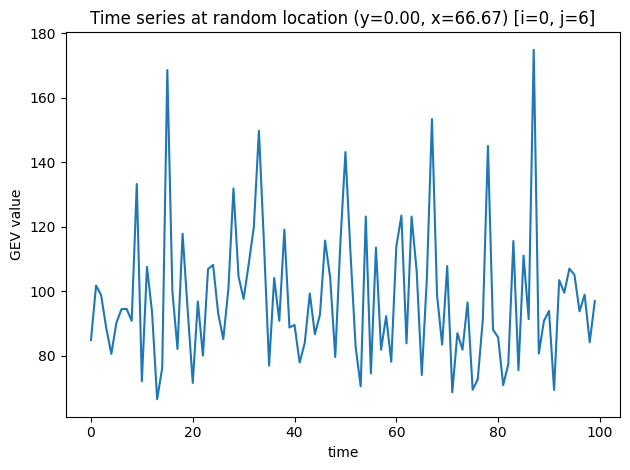

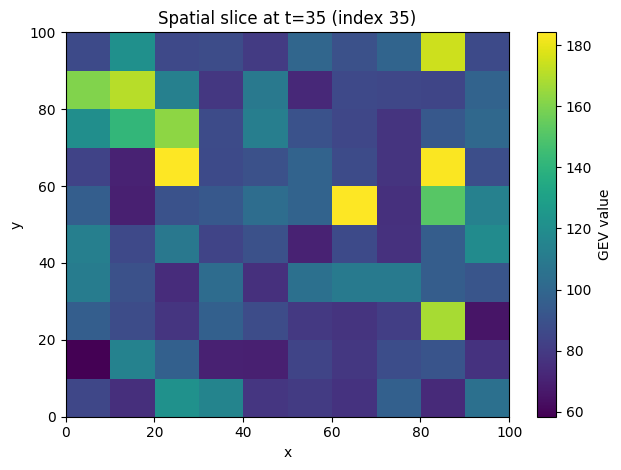

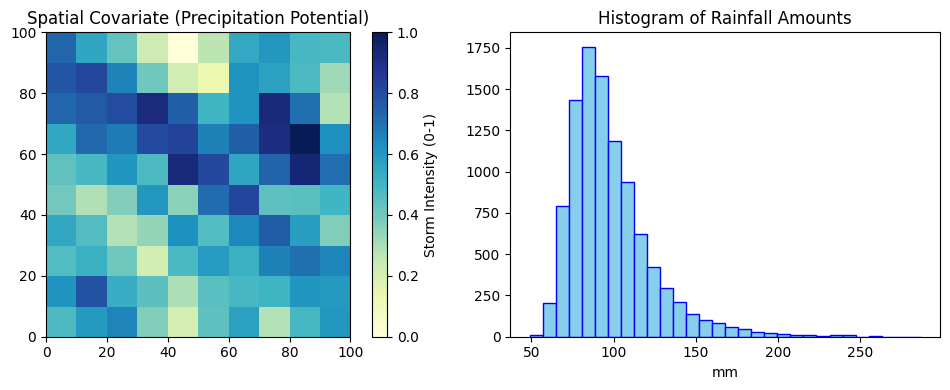

In [ ]:
gen_kwargs = dict(n_lat=10, n_lon=10, n_time=100,
                  beta_mu0=70, beta_mu_t=0, beta_ls0=np.log(11.0),beta_ls_s=np.log(2),beta_mu_s=30,xi_noise=False,xi_noise_amp=0.05)

data, meta = generate_gev_dataset_linear(**gen_kwargs,)
plot_random_time_series(data, meta)
plot_random_spatial_slice(data, meta)

# Plot the Field (Should range 0 to 1)
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
# Note: using a colormap like 'Blues' or 'YlGnBu' feels more like rain
im = plt.imshow(meta["s_field"], origin="lower", cmap="YlGnBu", extent=[0, 100, 0, 100])
plt.colorbar(im, label="Storm Intensity (0-1)")
plt.title("Spatial Covariate (Precipitation Potential)")

# Plot the resulting Data (Should be > 0)
plt.subplot(1, 2, 2)
plt.hist(data.flatten(), bins=30, color='skyblue', edgecolor='blue')
plt.title("Histogram of Rainfall Amounts")
plt.xlabel("mm")

plt.tight_layout()
plt.show()

In [50]:

def build_teacher(data, meta, n_jobs=-1, backend="threading"):
    """
    Fit a (time-only) GEV per pixel using the refactored JAX engine.
    Returns a teacher dict aligned to the current dataset.
    """
    from joblib import Parallel, delayed

    t_curve = np.asarray(meta["t_curve"], float)  # (T,)
    n_time, n_lat, n_lon = data.shape

    def fit_one(y_t):
        # exog with time covariate for location; scale/shape = intercept only
        exog = {"location": None, "scale": None, "shape": None}
        model = gev.GEVModel()
        fit = model.fit(endog=y_t.astype(float), exog=exog)

        # unpack params with the model’s linker
        d_loc, d_scale, d_shape = fit.dims
        beta_loc, beta_scale, beta_shape = fit.linker.forward(fit.params, fit.dims)

        exog_loc   = fit.data.exog_loc   # (T, 1, d_loc)
        exog_scale = fit.data.exog_scale # (T, 1, d_scale)
        exog_shape = fit.data.exog_shape # (T, 1, d_shape)

        mu_hat  = np.einsum("tsk,k->ts", exog_loc,   beta_loc)            # (T,1)
        lin_sc  = np.einsum("tsk,k->ts", exog_scale, beta_scale)
        sig_hat = fit.linker.np_transform_scale(lin_sc)                   # softplus
        xi_hat  = np.einsum("tsk,k->ts", exog_shape, beta_shape)

        return mu_hat[:, 0], sig_hat[:, 0], xi_hat[:, 0], True  # ok_mask=True

    # Parallel over pixels
    res = Parallel(n_jobs=n_jobs, backend=backend)(
        delayed(fit_one)(data[:, i, j]) for i in range(n_lat) for j in range(n_lon)
    )

    mu_hat  = np.empty((n_time, n_lat, n_lon))
    sig_hat = np.empty((n_time, n_lat, n_lon))
    xi_hat  = np.empty((n_time, n_lat, n_lon))
    ok_mask = np.zeros((n_lat, n_lon), bool)

    k = 0
    for i in range(n_lat):
        for j in range(n_lon):
            mu_hat[:, i, j], sig_hat[:, i, j], xi_hat[:, i, j], ok = res[k]; k += 1
            ok_mask[i, j] = ok

    return {
        "mu_hat":   mu_hat,
        "sigma_hat": sig_hat,
        "xi_hat":   xi_hat,
        "ok_mask":  ok_mask,
    }

teacher = build_teacher(data, meta)


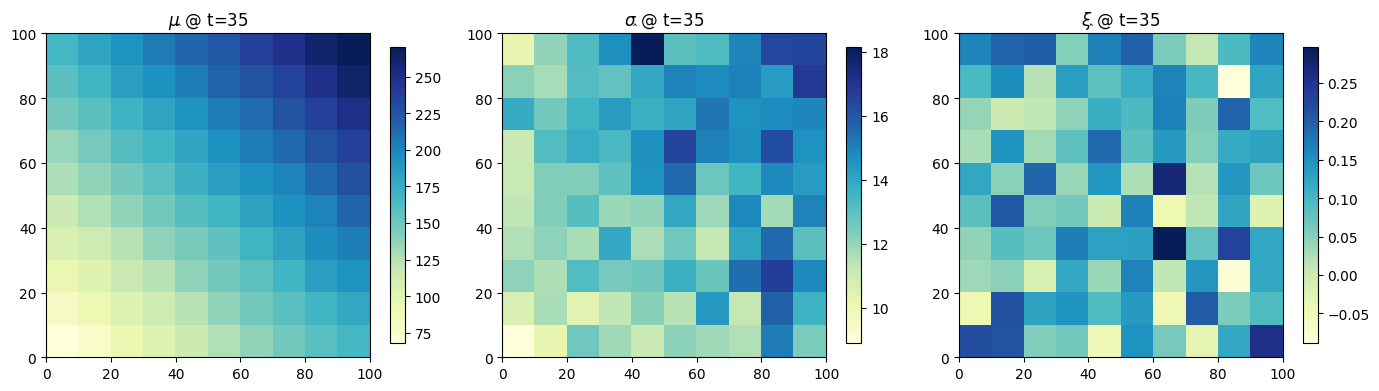

In [52]:
# === Marginal fit fields at t = 35: μ_hat, σ_hat, ξ_hat ===
t_plot = 35
extent = (meta["x"].min(), meta["x"].max(), meta["y"].min(), meta["y"].max()) if {"x","y"} <= set(meta) else None

fields = [teacher["mu_hat"][t_plot], teacher["sigma_hat"][t_plot], teacher["xi_hat"][t_plot]]
titles = [r"$\mu_{\hat{}}$", r"$\sigma_{\hat{}}$", r"$\xi_{\hat{}}$"]

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for ax, f, title in zip(axes, fields, titles):
    im = ax.imshow(f, origin="lower", extent=extent, cmap="YlGnBu")
    ax.set_title(f"{title} @ t={t_plot}")
    plt.colorbar(im, ax=ax, shrink=0.8)
plt.tight_layout()
plt.show()


Simulations pour les return levels (Marginal en n/2,n/2) (Par exemple ici en 5,5)

In [4]:
import numpy as np
from joblib import Parallel, delayed
from scipy.stats import genextreme

def compute_combined_sim(
    generate_fn,
    gen_kwargs,
    i,
    j,
    *,
    n_runs=5,
    return_periods=[100],
    t_idx=30,
    n_jobs_runs=-1,
    backend="threading",
    verbose=True,
    base_seed=2025,
    confidence=0.95,
    fit_mode="pointwise",
    weights=None,
    precompute_teacher=None,
    teacher_builder=None,
    selector_args=None,  # {"mode": "full|square|circle", "radius": ..., "max_points": ..., "include_center": True}
):
    """
    Decoupled GEV Simulation with optional local spatial selector in full mode.
    """

    sel_cfg = {
        "mode": "full",
        "radius": None,
        "max_points": None,
        "include_center": True,
    }
    if selector_args is not None:
        sel_cfg.update(selector_args)

    def calc_metrics(hats, trues, lowers, uppers):
        valid = (
            np.isfinite(hats)
            & np.isfinite(trues)
            & np.isfinite(lowers)
            & np.isfinite(uppers)
        )
        n_valid = int(valid.sum())

        if n_valid == 0:
            return {
                "rmse": np.nan,
                "mse": np.nan,
                "coverage_prob": np.nan,
                "mean_ci_width": np.nan,
                "n_valid": 0,
            }

        diff = hats[valid] - trues[valid]
        mse = float(np.mean(diff**2))
        rmse = float(np.sqrt(mse))
        is_covered = (lowers[valid] <= trues[valid]) & (trues[valid] <= uppers[valid])
        widths = uppers[valid] - lowers[valid]

        return {
            "rmse": rmse,
            "mse": mse,
            "coverage_prob": float(np.mean(is_covered)),
            "mean_ci_width": float(np.mean(widths)),
            "n_valid": n_valid,
        }

    def one_run(ridx):
        seed = base_seed + ridx
        try:
            data, meta = generate_fn(**gen_kwargs, seed=seed)
            n_time, n_lat, n_lon = data.shape
            s_total = n_lat * n_lon
            target_flat = int(i * n_lon + j)

            teacher = precompute_teacher
            if callable(weights):
                if teacher is None and callable(teacher_builder):
                    teacher = teacher_builder(data, meta)
                w_full = weights(
                    teacher=teacher,
                    i=i,
                    j=j,
                    t_idx=t_idx,
                    data_shape=data.shape,
                )
            else:
                w_full = weights

            if w_full is not None:
                if hasattr(w_full, "detach"):
                    w_full = w_full.detach().cpu().numpy()
                else:
                    w_full = np.asarray(w_full)

            if fit_mode == "full":
                if str(sel_cfg["mode"]).lower() != "full":
                    sel = select_spatial_neighborhood(
                        n_lat=n_lat,
                        n_lon=n_lon,
                        i=i,
                        j=j,
                        mode=sel_cfg["mode"],
                        radius=sel_cfg["radius"],
                        max_points=sel_cfg["max_points"],
                        include_center=bool(sel_cfg["include_center"]),
                    )
                    selected_idx = sel.flat_idx.astype(np.int64)
                    s_idx = int(sel.target_local_idx)
                    if selected_idx.size == 0:
                        raise ValueError("Selector returned no points.")
                    if s_idx < 0:
                        raise ValueError("Target point not included in selected neighborhood.")
                else:
                    selected_idx = np.arange(s_total, dtype=np.int64)
                    s_idx = target_flat

                endog_full = data.reshape(n_time, s_total).astype(float)
                endog = endog_full[:, selected_idx]

                if w_full is None:
                    w_subset = None
                else:
                    w_arr = np.asarray(w_full, dtype=float)
                    if w_arr.shape == data.shape:
                        w2d = w_arr.reshape(n_time, s_total)
                    elif w_arr.shape == (n_time, s_total):
                        w2d = w_arr
                    elif np.isscalar(w_arr) or w_arr.size == 1:
                        w2d = np.full((n_time, s_total), float(np.ravel(w_arr)[0]), dtype=float)
                    else:
                        raise ValueError(
                            f"Unsupported full weights shape {w_arr.shape}. "
                            f"Expected (T,H,W), (T,S), or scalar."
                        )
                    w_subset = w2d[:, selected_idx]

            else:
                endog = data[:, i, j].astype(float)
                s_idx = 0

                if w_full is None:
                    w_subset = None
                else:
                    w_arr = np.asarray(w_full, dtype=float)
                    if w_arr.shape == data.shape:
                        w_vec = w_arr[:, i, j]
                    elif w_arr.shape == (n_time, s_total):
                        w_vec = w_arr[:, target_flat]
                    elif w_arr.ndim == 1 and w_arr.size == n_time:
                        w_vec = w_arr
                    elif np.isscalar(w_arr) or w_arr.size == 1:
                        w_vec = np.full(n_time, float(np.ravel(w_arr)[0]), dtype=float)
                    else:
                        raise ValueError(
                            f"Unsupported pointwise weights shape {w_arr.shape}. "
                            f"Expected (T,H,W), (T,S), (T,), or scalar."
                        )
                    w_subset = np.asarray(w_vec, dtype=float).reshape(n_time, 1)

            if w_subset is not None:
                w_subset = np.asarray(w_subset, dtype=float)
                w_subset = np.nan_to_num(w_subset, nan=0.0, posinf=0.0, neginf=0.0)
                w_subset = np.clip(w_subset, 0.0, None)
                if float(w_subset.sum()) <= 0.0:
                    w_subset = None

            model = gev.GEVModel()
            fit = model.fit(
                endog=endog,
                exog={"location": None, "scale": None, "shape": None},
                weights=w_subset,
            )

            theta = fit.params
            lo, hi = fit.ci(confidence=confidence)

            mu_true = float(meta["mu"][t_idx, i, j])
            sig_true = float(meta["sigma"][t_idx, i, j])
            xi_true = float(meta["xi"][t_idx, i, j])

            res_params = {
                "u0": (theta[0], mu_true, lo[0], hi[0]),
                "sigma0": (theta[1], sig_true, lo[1], hi[1]),
                "xi0": (theta[2], xi_true, lo[2], hi[2]),
            }

            res_rls = {}
            t_arr = np.array(return_periods, dtype=float)
            rl_true_arr = genextreme.ppf(1.0 - 1.0 / t_arr, c=-xi_true, loc=mu_true, scale=sig_true)

            rl_obj, _, ci_obj = fit.return_level(t=t_idx, s=s_idx).compute(T=return_periods)
            for k, t_ret in enumerate(return_periods):
                res_rls[t_ret] = (
                    float(rl_obj[0, 0, k]),
                    float(rl_true_arr[k]),
                    float(ci_obj[0, 0, k, 0]),
                    float(ci_obj[0, 0, k, 1]),
                )

            return ridx, res_params, res_rls, None

        except Exception as e:
            return ridx, None, None, repr(e)

    results = (
        Parallel(n_jobs=n_jobs_runs, backend=backend, verbose=0)(delayed(one_run)(r) for r in range(n_runs))
        if n_jobs_runs != 1
        else [one_run(r) for r in range(n_runs)]
    )

    empty = np.full(n_runs, np.nan)
    raw_params = {k: [empty.copy() for _ in range(4)] for k in ["u0", "sigma0", "xi0"]}
    raw_rls = {t_ret: [empty.copy() for _ in range(4)] for t_ret in return_periods}

    n_success = 0
    true_params = None
    true_rls = None

    for ridx, p_res, r_res, err in results:
        if err:
            continue

        if true_params is None:
            true_params = {k: float(v[1]) for k, v in p_res.items()}
        if true_rls is None:
            true_rls = {str(t_ret): float(v[1]) for t_ret, v in r_res.items()}

        n_success += 1

        for k, v in p_res.items():
            for m in range(4):
                raw_params[k][m][ridx] = v[m]

        for t_ret, v in r_res.items():
            for m in range(4):
                raw_rls[t_ret][m][ridx] = v[m]

    final_output = {
        "pixel": (int(i), int(j)),
        "t_idx": int(t_idx),
        "n_runs": n_runs,
        "success_rate": n_success / n_runs,
        "true_params": true_params or {},
        "true_return_levels": true_rls or {},
        "gev_params": {k: calc_metrics(*raw_params[k]) for k in raw_params},
        "return_levels": {str(t_ret): calc_metrics(*raw_rls[t_ret]) for t_ret in raw_rls},
    }

    if verbose:
        w_str = "[Weighted]" if weights is not None else "[Unweighted]"
        print("=" * 75)
        print(f" SIMULATION REPORT | Pixel ({i},{j}) | {fit_mode} | {w_str}")
        print(f" Success: {n_success}/{n_runs} ({final_output['success_rate']:.1%}) | T_idx: {t_idx} | Conf: {confidence:.0%}")
        print("-" * 75)

        h_fmt = "{:<12} | {:<12} | {:<15} | {:<15} | {:<12}"
        row_fmt = "{:<12} | {:<12.4f} | {:<15.2%} | {:<15.4f} | {:<12.4f}"

        print(h_fmt.format("Metric", "RMSE", "Coverage", "Mean Width", "True"))
        print("-" * 75)

        for k in ["u0", "sigma0", "xi0"]:
            s = final_output["gev_params"][k]
            true_val = final_output["true_params"].get(k, np.nan)
            print(row_fmt.format(k, s["rmse"], s["coverage_prob"], s["mean_ci_width"], true_val))

        print("-" * 75)

        rl_keys = sorted(final_output["return_levels"].keys(), key=lambda x: int(x))
        for t_key in rl_keys:
            s = final_output["return_levels"][t_key]
            true_val = final_output["true_return_levels"].get(t_key, np.nan)
            print(row_fmt.format(f"RL_{t_key}", s["rmse"], s["coverage_prob"], s["mean_ci_width"], true_val))

        print("=" * 75 + "\n")

    return final_output


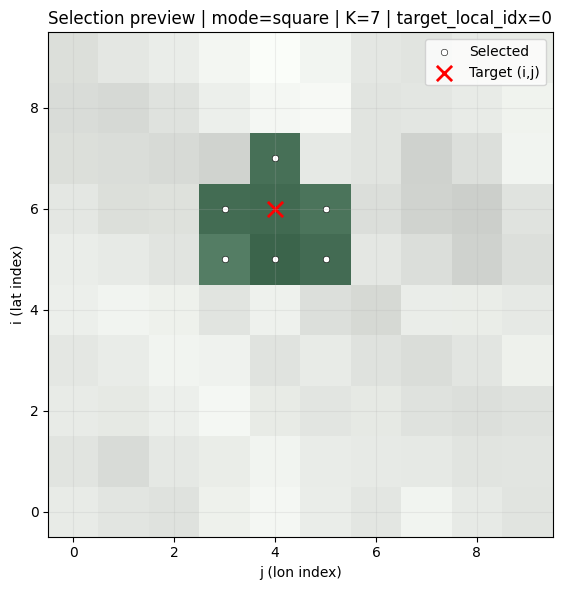

In [37]:
import matplotlib.pyplot as plt

def preview_selection(data_shape, i, j, selector_args=None, background=None):
    _, n_lat, n_lon = data_shape

    cfg = {
        "mode": "full",         # "full" | "square" | "circle"
        "radius": None,
        "max_points": None,
        "include_center": True,
    }
    if selector_args is not None:
        cfg.update(selector_args)

    # Mimic compute_combined_sim logic
    if cfg["mode"] == "full":
        mask = np.ones((n_lat, n_lon), dtype=bool)
        coords = np.column_stack(np.where(mask))
        target_local_idx = int(i * n_lon + j)
    else:
        sel = select_spatial_neighborhood(
            n_lat=n_lat,
            n_lon=n_lon,
            i=i,
            j=j,
            mode=cfg["mode"],
            radius=cfg["radius"],
            max_points=cfg["max_points"],
            include_center=cfg["include_center"],
        )
        mask = sel.mask
        coords = sel.coords
        target_local_idx = sel.target_local_idx

    fig, ax = plt.subplots(figsize=(6, 6))

    if background is not None:
        ax.imshow(background, origin="lower", cmap="Greys", alpha=0.45)

    # selection area
    ax.imshow(mask.astype(float), origin="lower", cmap="Greens", alpha=0.6, vmin=0, vmax=1)

    # selected points and target
    if coords.size > 0:
        ax.scatter(coords[:, 1], coords[:, 0], s=22, c="white", edgecolors="black", linewidths=0.4, label="Selected")
    ax.scatter([j], [i], s=120, c="red", marker="x", linewidths=2.0, label="Target (i,j)")

    ax.set_title(
        f"Selection preview | mode={cfg['mode']} | K={len(coords)} | target_local_idx={target_local_idx}"
    )
    ax.set_xlabel("j (lon index)")
    ax.set_ylabel("i (lat index)")
    ax.set_xlim(-0.5, n_lon - 0.5)
    ax.set_ylim(-0.5, n_lat - 0.5)
    ax.grid(alpha=0.2)
    ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

# Example
selector_args = {
    "mode": "square",      # "square" or "circle"
    "radius": 1,        # None => full-grid fallback
    "max_points": 7,      # direct control
    "include_center": True
}

preview_selection(
    data_shape=data.shape,  # (T,H,W)
    i=6, j=4,
    selector_args=selector_args,
    background=meta.get("s_field", None)  # optional
)

In [98]:

def ones_weight_adapter(*, teacher=None, i=None, j=None, t_idx=None, data_shape=None, **kwargs):
    n_time, n_lat, n_lon = data_shape
    return 0.024*np.ones((n_time, n_lat, n_lon), dtype=np.float64)

results = compute_combined_sim(
    generate_fn=generate_gev_dataset_linear,
    gen_kwargs=gen_kwargs,
    i=6, j=4,
    n_runs=100,
    return_periods=[10, 100, 1000,5000],
    t_idx=30,
    n_jobs_runs=-1,
    verbose=True,
    fit_mode="pointwise",                 # selector is used in full mode
    precompute_teacher=teacher,
)

 SIMULATION REPORT | Pixel (6,4) | pointwise | [Unweighted]
 Success: 100/100 (100.0%) | T_idx: 30 | Conf: 95%
---------------------------------------------------------------------------
Metric       | RMSE         | Coverage        | Mean Width      | True        
---------------------------------------------------------------------------
u0           | 1.7415       | 90.00%          | 6.0407          | 103.3333    
sigma0       | 1.3043       | 89.00%          | 4.3827          | 13.7791     
xi0          | 0.0808       | 88.00%          | 0.2705          | 0.1000      
---------------------------------------------------------------------------
RL_10        | 4.1539       | 94.00%          | 16.2310         | 138.1075    
RL_100       | 14.3184      | 88.00%          | 57.4167         | 183.8168    
RL_1000      | 39.8515      | 86.00%          | 153.9218        | 240.4579    
RL_5000      | 73.0185      | 85.00%          | 273.9938        | 288.4763    



In [70]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def compute_sim_grid(generate_fn, gen_kwargs, max_i=None, max_j=None, return_period=100, **sim_kwargs):
    # probe shape
    data, _ = generate_fn(**gen_kwargs, seed=sim_kwargs.get("base_seed", 2025))
    _, H, W = data.shape
    I = max_i if max_i is not None else H
    J = max_j if max_j is not None else W

    rmse = np.full((H, W), np.nan)
    cov  = np.full((H, W), np.nan)
    width = np.full((H, W), np.nan)

    for i in range(I):
        for j in range(J):
            out = compute_combined_sim(
                generate_fn=generate_fn,
                gen_kwargs=gen_kwargs,
                i=i, j=j,
                return_periods=[return_period],
                verbose = True,
                **sim_kwargs,
            )
            m = out["return_levels"][str(return_period)]
            rmse[i, j]  = m["rmse"]
            cov[i, j]   = m["coverage_prob"]
            width[i, j] = m["mean_ci_width"]
    return {"rmse": rmse, "cov": cov, "width": width}

def plot_metric_grid(metric, title, filename=None, vmin=None, vmax=None, cmap=None):
    arr = np.asarray(metric)
    plt.figure(figsize=(6,5))
    im = plt.imshow(arr, origin="lower", cmap=cmap, vmin=vmin, vmax=vmax)
    plt.colorbar(im, label=title)
    plt.title(title)
    plt.tight_layout()
    if filename:
        out = Path.home() / "Documents" / "SavedFigures" / filename
        plt.savefig(out, dpi=200)
        print(f"Saved plot to {out}")
    plt.show()

def ones_weight_adapter(*, teacher=None, i=None, j=None, t_idx=None, data_shape=None, **kwargs):
    n_time, n_lat, n_lon = data_shape
    return np.ones((n_time, n_lat, n_lon), dtype=np.float64)


# Example usage:
grid = compute_sim_grid(
    generate_fn=generate_gev_dataset_linear,
    gen_kwargs=gen_kwargs,
    max_i=3, max_j=3,            # limit to a small sub-grid
    n_runs=10,
    fit_mode="pointwise",
    precompute_teacher = teacher,
    weights=ones_weight_adapter
)

# RMSE: green=0, red=max
plot_metric_grid(grid["rmse"], "RMSE", vmin=0.0, vmax=12, cmap=plt.cm.RdYlGn_r,filename="rmse_grid_p.png")
# Coverage: red=0, green=1
plot_metric_grid(grid["cov"], "Coverage", vmin=0.0, vmax=1.0, cmap=plt.cm.RdYlGn,filename="coverage_grid_p.png")
# CI width: green=0, red=max
plot_metric_grid(grid["width"], "Mean CI Width", vmin=0.0, vmax=55, cmap=plt.cm.RdYlGn_r,filename="width_grid_p.png")


KeyboardInterrupt: 

In [10]:
import numpy as np
import torch
import torch.nn as tnn

class NeuralWeightAdapter:
    def __init__(self, net, mu_scale, logsig_scale, xi_scale, min_weight=0.0):
        self.net = net
        self.min_weight = min_weight
        self.device = next(net.parameters()).device
        
        # Global scales for normalization
        self.s_mu_sq = float(mu_scale)**2 + 1e-8
        self.s_ls_sq = float(logsig_scale)**2 + 1e-8
        self.s_xi_sq = float(xi_scale)**2 + 1e-8

    def __call__(self, teacher, i, j, t_idx, data_shape, **kwargs):
        """
        Args:
            teacher (dict): Contains 'mu_hat', 'sigma_hat', 'xi_hat' (T, Lat, Lon)
            i, j (int): Target pixel coords
            t_idx (int): Time index
            data_shape (tuple): (T, H, W)
        """
        self.net.eval()
        n_time, n_lat, n_lon = data_shape
        n_series = n_lat * n_lon
        
        # 1. Use TEACHER Predictions (Noisy), not Meta (Truth)
        mu_pred  = np.asarray(teacher["mu_hat"], dtype=np.float32)
        sig_pred = np.asarray(teacher["sigma_hat"], dtype=np.float32)
        xi_pred  = np.asarray(teacher["xi_hat"], dtype=np.float32)
        logs_pred = np.log(np.clip(sig_pred, 1e-12, None))

        # 2. Slice Reference vs Neighbors
        tref = int(np.clip(t_idx, 0, n_time - 1))
        
        # The "Query" (Target Pixel)
        mu_ref = float(mu_pred[tref, i, j])
        ls_ref = float(logs_pred[tref, i, j])
        xi_ref = float(xi_pred[tref, i, j])

        # The "Keys" (All Pixels)
        mu_flat = mu_pred[tref].reshape(n_series)
        ls_flat = logs_pred[tref].reshape(n_series)
        xi_flat = xi_pred[tref].reshape(n_series)

        # 3. Neural Inference (GPU)
        with torch.inference_mode():
            # Calculate Normalized Squared Differences of PREDICTIONS
            d_mu_sq = (torch.tensor(np.abs(mu_flat - mu_ref)**2, device=self.device) / self.s_mu_sq)
            d_ls_sq = (torch.tensor(np.abs(ls_flat - ls_ref)**2, device=self.device) / self.s_ls_sq)
            d_xi_sq = (torch.tensor(np.abs(xi_flat - xi_ref)**2, device=self.device) / self.s_xi_sq)

            X = torch.stack([d_mu_sq, d_ls_sq, d_xi_sq], dim=-1).float()
            
            # Forward Pass
            w_raw = self.net(X).squeeze(-1)
            
        # 4. Post-Process (stay in torch)
        tau = getattr(self.net, "tau", 1.0)
        logits = w_raw.reshape(1, n_lat, n_lon)               # (1,H,W)

        if "ok_mask" in teacher:
            mask_flat = torch.as_tensor(teacher["ok_mask"].reshape(-1), device=self.device, dtype=torch.bool)
            logits_flat = logits.reshape(1, -1).masked_fill(~mask_flat, -1e9)
        else:
            logits_flat = logits.reshape(1, -1)

        w_flat = torch.softmax(logits_flat / tau, dim=1)        # (1, H*W)
        w_spatial = w_flat.reshape(1, n_lat, n_lon)             # (1, H, W)
        w_spatial = w_spatial.expand(n_time, -1, -1).cpu().numpy()  # tile over time
        return w_spatial


In [11]:
import numpy as np
from sklearn.model_selection import train_test_split

def build_splits(
    data: np.ndarray,
    mu_hat: np.ndarray,
    sig_hat: np.ndarray,
    xi_hat: np.ndarray,
    ok_mask: np.ndarray | None = None,
    mode: str = "space-time",
    test_size: float = 0.20,
    val_ratio: float = 0.50,
    random_state: int = 42,
):
    """
    Build train / val / test splits either:
      - mode="space-time": samples are (t, i, j) points, 1D arrays
      - mode="time":       samples are full time slices, vectors over space

    Returns a nested dict like:
    {
        "mode": "space-time" or "time",
        "indices": {...},       # bookkeeping info (time indices, sample indices, etc.)
        "train":  {"mu": ..., "sigma": ..., "xi": ..., "y": ...},
        "val":    {...},
        "test":   {...},
    }
    """
    T, H, W = data.shape
    S = H * W

    if mode not in {"space-time", "time"}:
        raise ValueError(f"Unknown mode {mode!r}, use 'space-time' or 'time'.")

    # ------------------------------
    # COMMON: handle ok_mask → space mask
    # ------------------------------
    if ok_mask is not None:
        if ok_mask.shape != (H, W):
            raise ValueError(f"ok_mask shape {ok_mask.shape} must be (H, W)=({H},{W})")
        space_mask = ok_mask.reshape(-1)  # (S,)
    else:
        space_mask = np.ones(S, dtype=bool)

    # ------------------------------
    # MODE 1: SPACE-TIME (flatten T,H,W → N)
    # ------------------------------
    if mode == "space-time":
        def flatten3(a3: np.ndarray) -> np.ndarray:
            """Flatten (T,H,W) to (N,) and apply space mask."""
            a2 = a3.reshape(T, S)          # (T, S)
            a2 = a2[:, space_mask]         # (T, S_eff)
            return a2.reshape(-1).astype(np.float32)  # (N,)

        y_flat       = flatten3(data)
        mu_hat_flat  = flatten3(mu_hat)
        sig_hat_flat = flatten3(sig_hat)
        xi_hat_flat  = flatten3(xi_hat)

        N = y_flat.shape[0]
        idx_all = np.arange(N)

        # 80 / 10 / 10 split on samples
        idx_tr, idx_tmp = train_test_split(
            idx_all, test_size=test_size, random_state=random_state, shuffle=True
        )
        idx_val, idx_te = train_test_split(
            idx_tmp, test_size=val_ratio, random_state=random_state, shuffle=True
        )

        def take(idx: np.ndarray):
            """Return (μ̂, σ̂, ξ̂, y) for sample indices."""
            return (
                mu_hat_flat[idx],
                sig_hat_flat[idx],
                xi_hat_flat[idx],
                y_flat[idx],
            )

        (mu_tr, sigma_tr, xi_tr, y_tr)     = take(idx_tr)
        (mu_val, sigma_val, xi_val, y_val) = take(idx_val)
        (mu_te, sigma_te, xi_te, y_te)     = take(idx_te)

        return {
            "mode": "space-time",
            "indices": {
                "N": N,
                "idx_all": idx_all,
                "idx_train": idx_tr,
                "idx_val": idx_val,
                "idx_test": idx_te,
            },
            "train": {
                "mu": mu_tr,
                "sigma": sigma_tr,
                "xi": xi_tr,
                "y": y_tr,
            },
            "val": {
                "mu": mu_val,
                "sigma": sigma_val,
                "xi": xi_val,
                "y": y_val,
            },
            "test": {
                "mu": mu_te,
                "sigma": sigma_te,
                "xi": xi_te,
                "y": y_te,
            },
        }

    # ------------------------------
    # MODE 2: TIME (split over T, keep space vectors)
    # ------------------------------
    else:  # mode == "time"
        def flatten_space(a3: np.ndarray) -> np.ndarray:
            """Flatten space only: (T,H,W) → (T, S_eff)."""
            a2 = a3.reshape(T, S)      # (T, S)
            a2 = a2[:, space_mask]     # (T, S_eff)
            return a2.astype(np.float32)

        y_2d   = flatten_space(data)      # (T, S_eff)
        mu_2d  = flatten_space(mu_hat)    # (T, S_eff)
        sig_2d = flatten_space(sig_hat)   # (T, S_eff)
        xi_2d  = flatten_space(xi_hat)    # (T, S_eff)

        idx_t = np.arange(T)

        # 80 / 10 / 10 split on time indices
        idx_tr_t, idx_tmp_t = train_test_split(
            idx_t, test_size=test_size, random_state=random_state, shuffle=True
        )
        idx_val_t, idx_te_t = train_test_split(
            idx_tmp_t, test_size=val_ratio, random_state=random_state, shuffle=True
        )

        def take_time(idx_t_arr: np.ndarray):
            """Return (μ̂, σ̂, ξ̂, y) for time indices (rows)."""
            return (
                mu_2d[idx_t_arr, :],   # (T_split, S_eff)
                sig_2d[idx_t_arr, :],
                xi_2d[idx_t_arr, :],
                y_2d[idx_t_arr, :],
            )

        (mu_tr, sigma_tr, xi_tr, y_tr)     = take_time(idx_tr_t)
        (mu_val, sigma_val, xi_val, y_val) = take_time(idx_val_t)
        (mu_te, sigma_te, xi_te, y_te)     = take_time(idx_te_t)

        return {
            "mode": "time",
            "indices": {
                "T": T,
                "time_idx_all": idx_t,
                "time_idx_train": idx_tr_t,
                "time_idx_val": idx_val_t,
                "time_idx_test": idx_te_t,
            },
            "train": {
                # each row is a time; each column is a spatial location
                "mu": mu_tr,
                "sigma": sigma_tr,
                "xi": xi_tr,
                "y": y_tr,
            },
            "val": {
                "mu": mu_val,
                "sigma": sigma_val,
                "xi": xi_val,
                "y": y_val,
            },
            "test": {
                "mu": mu_te,
                "sigma": sigma_te,
                "xi": xi_te,
                "y": y_te,
            },
        }
        
splits_st = build_splits(data, teacher["mu_hat"], teacher["sigma_hat"], teacher["xi_hat"], ok_mask=teacher["ok_mask"], mode="space-time",test_size=0.05)
splits_t  = build_splits(data, teacher["mu_hat"], teacher["sigma_hat"], teacher["xi_hat"], ok_mask=teacher["ok_mask"], mode="time",test_size=0.05)
y_tr = splits_st["train"]["y"]
y_tr.shape

(9500,)

In [12]:
# ============================ μ, logσ, ξ 3-feature kernel + GEV-NLL + ESS ============================
import numpy as np
import torch
import torch.nn as tnn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[PyTorch] device: {device}")

# ---------- helpers: sampling, ESS, normalization ----------
EPS = 1e-8

@torch.inference_mode()
def estimate_global_dist_scale(locs: torch.Tensor, num_pairs: int = 200_000) -> torch.Tensor:
    """Robust scale for pairwise distances: median over a random subset of pairs. locs: (N,D)"""
    N = locs.shape[0]
    if N < 2:
        return torch.tensor(1.0, device=locs.device)
    M = min(num_pairs, max(1, N * (N - 1)))
    i = torch.randint(0, N, (M,), device=locs.device)
    j = torch.randint(0, N - 1, (M,), device=locs.device)
    j = j + (j >= i).long()  # skip-self trick
    d = torch.linalg.norm(locs[i] - locs[j], dim=-1)
    return torch.median(d)

def sample_uniform_partners(batch_query_idx: torch.Tensor, K: int, N: int) -> torch.Tensor:
    """
    For each query index q, sample K distinct partner indices from [0,...,N-1]/[q].
    Returns LongTensor of shape (B, K).
    """
    B = batch_query_idx.shape[0]
    partners = torch.empty((B, K), dtype=torch.long, device=batch_query_idx.device)
    for b in range(B):
        q = int(batch_query_idx[b].item())
        idx = torch.randperm(N - 1, device=batch_query_idx.device)[:K]
        partners[b] = idx + (idx >= q)
    return partners

@torch.inference_mode()
def ess_rows_from_raw(W: torch.Tensor) -> torch.Tensor:
    row_sum = torch.sum(W, dim=1) + EPS
    return (row_sum * row_sum) / (torch.sum(W * W, dim=1) + EPS)

def rowsum_normalize_masked(W_raw: torch.Tensor, mask: torch.Tensor, eps: float = 1e-8):
    """
    Normalize per row after zeroing out masked entries.
    If a row has no valid entries, return zeros in that row (caller will handle).
    """
    Wm = W_raw * mask
    s = Wm.sum(dim=1, keepdim=True)
    W = torch.where(s > eps, Wm / s.clamp_min(eps), torch.zeros_like(Wm))
    return W, (s.squeeze(1) <= eps)  # no_valid_row: (B,)

def rowsum_normalize(W: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    return W / (W.sum(dim=1, keepdim=True).clamp_min(eps))

def masked_softmax(logits: torch.Tensor, mask: torch.Tensor, tau: float = 1.0):
    logits = logits / tau
    logits = logits + (1.0 - mask) * (-1e9)  # -inf on invalid
    w = torch.softmax(logits, dim=1)
    return w * mask

def teacher_from_truth(data, meta):
    return {
        "mu_hat":    np.asarray(meta["mu"], dtype=np.float32),
        "sigma_hat": np.asarray(meta["sigma"], dtype=np.float32),
        "xi_hat":    np.asarray(meta["xi"], dtype=np.float32),
        "ok_mask":   np.ones_like(meta["mu"][0], dtype=bool),
    }


# ---------- GEV NLL with domain masking and safe fallback ----------
def query_weighted_gev_nll_loss(
    W_raw: torch.Tensor,
    mu_n: torch.Tensor,
    sigma_n: torch.Tensor,
    xi_n: torch.Tensor,
    y_q: torch.Tensor,
    *,
    tau: float = 1.0,
    sigma_min: float = 1e-5,   # a bit higher to avoid huge z
    xi_eps: float = 1e-6,
    t_min: float = 1e-12,
    exp_clip: float = 40.0
) -> torch.Tensor:
    """
    Weighted GEV NLL with:
      - domain mask (t>0) before weight normalization,
      - ξ→0 Gumbel limit branch,
      - row-level fallback to Gumbel when no valid partners exist.
    Shapes:
      *_n and W_raw: (B,K), y_q: (B,)
    """
    B, K = W_raw.shape
    y  = y_q.view(B, 1)
    beta = sigma_n.clamp_min(sigma_min)
    xi   = xi_n

    # ξ≈0 branch precomputed (valid everywhere): Gumbel
    z = (y - mu_n) / beta
    nll_gumbel = torch.log(beta) + z + torch.exp(torch.clamp(-z, max=exp_clip))

    # General GEV branch
    t = 1.0 + xi * (y - mu_n) / beta                 # support requires t > 0
    valid = t > 0.0

    small_xi = xi.abs() < xi_eps
    large_xi = ~small_xi

    t_clamped = torch.clamp(t, min=t_min)
    log_t = torch.log(t_clamped)

    inv_xi = torch.empty_like(xi)
    inv_xi[large_xi] = 1.0 / xi[large_xi]

    pow_term = torch.zeros_like(log_t)
    pow_term[large_xi] = torch.exp(
        torch.clamp(-inv_xi[large_xi] * log_t[large_xi], min=-exp_clip, max=exp_clip)
    )

    nll_gev = torch.log(beta) + (1.0 + inv_xi) * log_t + pow_term

    # per-pair NLL: use GEV where valid & ξ≠0; use Gumbel otherwise
    use_gev = valid & large_xi
    nll_pair = torch.where(use_gev, nll_gev, nll_gumbel)

    # normalize weights AFTER masking invalid pairs
    W = masked_softmax(W_raw, valid.float(), tau=tau)
    no_valid_row = valid.sum(dim=1) == 0
    if no_valid_row.any():
        W_fallback = torch.softmax(W_raw / tau, dim=1)
        loss_rows = (W * nll_pair).sum(dim=1)
        loss_rows_fallback = (W_fallback * nll_gumbel).sum(dim=1)
        loss_rows = torch.where(no_valid_row, loss_rows_fallback, loss_rows)
        return loss_rows.mean()
    return (W * nll_pair).sum(dim=1).mean()



# ---------- tiny kernel net (3 features) ----------
class DynamicWeightNet(tnn.Module):
    def __init__(self, in_dim=3, hidden_dims=(32,16), bias_init=0.0, tau=1.0):
        super().__init__()
        layers, last = [], in_dim
        for h in hidden_dims:
            layers += [tnn.Linear(last, h), tnn.ReLU()]
            last = h
        self.backbone = tnn.Sequential(*layers)
        self.out = tnn.Linear(last, 1)
        self.tau = tau
        with torch.no_grad():
            self.out.bias.fill_(bias_init)  # e.g., 0.0

    def forward(self, x):  # logits (B*K,1)
        return self.out(self.backbone(x))


[PyTorch] device: cpu


In [11]:


# ============================ tensors from splits_st (space-time) ============================

train_st = splits_st["train"]

# NumPy arrays from the split (1D, length N)
mu_train_np    = train_st["mu"]
sigma_train_np = train_st["sigma"]
xi_train_np    = train_st["xi"]
y_train_np             = train_st["y"]

# to torch
mu_train    = torch.from_numpy(mu_train_np.astype(np.float32)).to(device)      # (N,)
sigma_train = torch.from_numpy(sigma_train_np.astype(np.float32)).to(device)   # (N,)
xi_train      = torch.from_numpy(xi_train_np.astype(np.float32)).to(device)      # (N,)
y_train       = torch.from_numpy(y_train_np.astype(np.float32)).to(device)               # (N,)

# log-σ for the second feature
lsig_train = torch.log(sigma_train.clamp_min(1e-12))                      # (N,)

# robust scales (train only) — treat each param as 1D locs (N,1)
with torch.inference_mode():
    mu_scale     = estimate_global_dist_scale(mu_train.view(-1, 1))              # median |Δμ|
    logsig_scale = estimate_global_dist_scale(lsig_train.view(-1, 1))         # median |Δlogσ|
    xi_scale     = estimate_global_dist_scale(xi_train.view(-1, 1))                # median |Δξ|
print(f"[scales] med |Δμ|={float(mu_scale):.6f} | med |Δlogσ|={float(logsig_scale):.6f} | med |Δξ|={float(xi_scale):.6f}")

# ============================ training with ESS-based early stop ============================
K_SAMPLES         = 1000
epochs            = 30
batch_size        = 206
lr                = 1e-4
patience          = 300
ESS_MIN_THRESHOLD = 20
ESS_SAMPLE_SIZE   = 250

net   = DynamicWeightNet(in_dim=3).to(device)
optim = torch.optim.Adam(net.parameters(), lr=lr)

N = y_train.shape[0]
best_train_loss = float('inf')
best_state = {k: v.detach().cpu().clone() for k, v in net.state_dict().items()}
patience_counter = 0

def _build_features(q_idx: torch.Tensor, i_idx: torch.Tensor):
    """
    Returns X: (B*K, 3) with columns:
      d_μ       = ((Δμ)^2)        / med(|Δμ|)^2
      d_logσ    = ((Δlogσ)^2)     / med(|Δlogσ|)^2
      d_ξ       = ((Δξ)^2)        / med(|Δξ|)^2
    """
    B, K = i_idx.shape

    # μ feature (index into the single μ vector)
    mu_q = mu_train.index_select(0, q_idx).unsqueeze(1)                    # (B,1)
    mu_i = mu_train.index_select(0, i_idx.view(-1)).view(B, K)            # (B,K)
    d_mu = torch.abs(mu_i - mu_q)                                             # (B,K)
    f_mu = (d_mu ** 2) / ((mu_scale ** 2) + 1e-8)

    # logσ feature
    logsig_q = lsig_train.index_select(0, q_idx).unsqueeze(1)          # (B,1)
    logsig_i = lsig_train.index_select(0, i_idx.view(-1)).view(B, K)   # (B,K)
    d_lsig   = torch.abs(logsig_i - logsig_q)
    f_lsig   = (d_lsig ** 2) / ((logsig_scale ** 2) + 1e-8)

    # ξ feature
    xi_q = xi_train.index_select(0, q_idx).unsqueeze(1)                      # (B,1)
    xi_i = xi_train.index_select(0, i_idx.view(-1)).view(B, K)               # (B,K)
    d_xi = torch.abs(xi_i - xi_q)
    f_xi = (d_xi ** 2) / ((xi_scale ** 2) + 1e-8)

    X = torch.stack([f_mu, f_lsig, f_xi], dim=-1).reshape(-1, 3)               # (B*K,3)
    return X, (B, K)

train_loss_hist = []
ess_hist = []
print(f"\nTraining 3-feature kernel with ESS early stop (threshold={ESS_MIN_THRESHOLD})...")

for epoch in range(1, epochs + 1):
    net.train()
    prev_state_epoch = {k: v.detach().cpu().clone() for k, v in net.state_dict().items()}  # for ESS revert

    perm = torch.randperm(N, device=device)
    epoch_loss, num_batches = 0.0, int(np.ceil(N / batch_size))

    for b in range(num_batches):
        s, e = b * batch_size, min((b + 1) * batch_size, N)
        if s >= e:
            continue

        q_idx = perm[s:e]                                    # (B,)
        yq    = y_train.index_select(0, q_idx)             # (B,)
        i_idx = sample_uniform_partners(q_idx, K_SAMPLES, N) # (B,K)

        # ----- build 3-feature inputs -----
        X, bk_shape = _build_features(q_idx, i_idx)          # X: (B*K,3), bk_shape=(B,K)

        # teacher params for partners
        mu_b    = mu_train.index_select(0, i_idx.view(-1)).view(bk_shape)
        sigma_b = sigma_train.index_select(0, i_idx.view(-1)).view(bk_shape)
        xi_b    = xi_train.index_select(0, i_idx.view(-1)).view(bk_shape)

        # weights
        W_raw = net(X).view(bk_shape)                        # (B,K)

        # GEV NLL
        loss  = query_weighted_gev_nll_loss(W_raw, mu_b, sigma_b, xi_b, yq)

        optim.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
        optim.step()

        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / max(1, num_batches)

    # --------- ESS early stop (raw weights, no masking) ---------
    net.eval()
    with torch.no_grad():
        M = int(min(ESS_SAMPLE_SIZE, N))
        sample_q = torch.randperm(N, device=device)[:M]                 # (M,)
        sample_i = sample_uniform_partners(sample_q, K_SAMPLES, N)      # (M,K)
        Xs, mk_shape = _build_features(sample_q, sample_i)
        logits_s = net(Xs).view(mk_shape)
        W_s = torch.softmax(logits_s / net.tau, dim=1)  # apply same tau
        mean_ess = float(ess_rows_from_raw(W_s).mean().item())

    train_loss_hist.append(avg_train_loss)
    ess_hist.append(mean_ess)

    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | train NLL: {avg_train_loss:.6f} | mean ESS ≈ {mean_ess:.1f}")

    if mean_ess < ESS_MIN_THRESHOLD:
        print(f"\n!!! Early stopping: mean ESS {mean_ess:.1f} < threshold {ESS_MIN_THRESHOLD:.1f}. "
              f"Reverting to previous epoch state. !!!")
        net.load_state_dict(prev_state_epoch)
        best_state = prev_state_epoch
        break

    if avg_train_loss < best_train_loss:
        best_train_loss = avg_train_loss
        best_state = {k: v.detach().cpu().clone() for k, v in net.state_dict().items()}
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Training stopped early at epoch {epoch}.")
            break

# restore best
net.load_state_dict(best_state)
print(f"Final best train NLL: {best_train_loss:.6f}")

# =====================================================================================================
import matplotlib.pyplot as plt

ess_arr = np.array(ess_hist)
nll_arr = np.array(train_loss_hist)
print(nll_arr)

plt.figure()
plt.plot(ess_arr, nll_arr, marker="o")
plt.xlabel("Mean effective sample size (ESS)")
plt.ylabel("Train NLL")
plt.title("Train NLL vs Effective Sample Size")
plt.grid(True)
plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()

epochs_arr = np.arange(1, len(train_loss_hist) + 1)

plt.figure()
plt.plot(epochs_arr, train_loss_hist, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Train NLL")
plt.title("Train NLL vs Epoch")
plt.grid(True)
plt.tight_layout()
plt.show()


[scales] med |Δμ|=3.892067 | med |Δlogσ|=0.120214 | med |Δξ|=0.076236

Training 3-feature kernel with ESS early stop (threshold=20)...


KeyboardInterrupt: 


Starting Training with Decoupled Simulation Validation...

Epoch 001 | NLL: 4476.0959 | ESS: 89.9 | RMSE: nan | Cov: nan%
Epoch 002 | NLL: 3132.7128 | ESS: 85.5 | RMSE: nan | Cov: nan%
Epoch 003 | NLL: 2830.7306 | ESS: 80.4 | RMSE: nan | Cov: nan%
Epoch 004 | NLL: 1682.7555 | ESS: 74.5 | RMSE: nan | Cov: nan%
Epoch 005 | NLL: 795.2112 | ESS: 68.0 | RMSE: nan | Cov: nan%
Epoch 006 | NLL: 475.2532 | ESS: 61.4 | RMSE: nan | Cov: nan%
Epoch 007 | NLL: 247.9726 | ESS: 55.1 | RMSE: nan | Cov: nan%
Epoch 008 | NLL: 129.0505 | ESS: 49.2 | RMSE: nan | Cov: nan%
Epoch 009 | NLL: 72.7232 | ESS: 44.1 | RMSE: nan | Cov: nan%
Epoch 010 | NLL: 44.7151 | ESS: 39.9 | RMSE: nan | Cov: nan%
!! ESS Collapse Detected. Stopping.

Generating Dashboard...


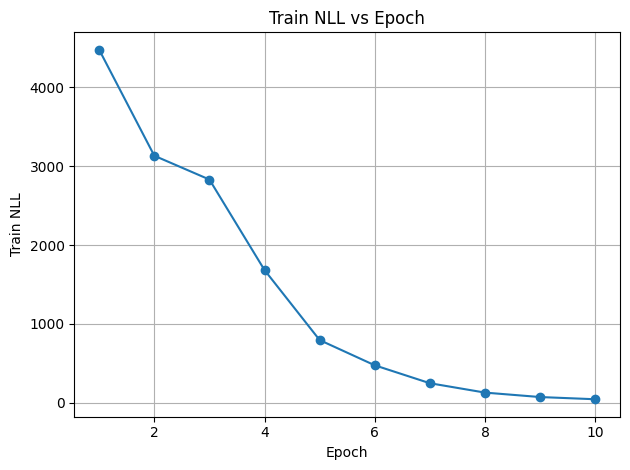

In [88]:
import numpy as np
import torch
import torch.nn as tnn
import matplotlib.pyplot as plt
from scipy.stats import genextreme
import time

# toggles
DO_SIM_VALIDATION = False

# ==============================================================================
# 2. Setup & Initialization
# ==============================================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Hyperparameters ---
K_SAMPLES = 1000
epochs = 60
batch_size_space = 100
lr = 1e-4
patience = 300
ESS_MIN_THRESHOLD = 40
ESS_SAMPLE_Q = 256

# --- Validation Config ---
TEST_I, TEST_J = 5,5
TEST_T_IDX = 30
TEST_RETURN_T = 10
N_VAL_RUNS = 10 # Low number for speed during training loop

# --- Prepare Scales (Robust Global Scales) ---
# (Assumes train_t data is already loaded in splits_t)
train_t = splits_t["train"]
mu_train  = torch.from_numpy(train_t["mu"].astype(np.float32)).to(device)
sig_train = torch.from_numpy(train_t["sigma"].astype(np.float32)).to(device)
xi_train  = torch.from_numpy(train_t["xi"].astype(np.float32)).to(device)
y_train   = torch.from_numpy(train_t["y"].astype(np.float32)).to(device)
lsig_train = torch.log(sig_train.clamp_min(1e-12))

T_tr, S = mu_train.shape
with torch.inference_mode():
    mu_scale     = estimate_global_dist_scale(mu_train.reshape(-1, 1))
    logsig_scale = estimate_global_dist_scale(lsig_train.reshape(-1, 1))
    xi_scale     = estimate_global_dist_scale(xi_train.reshape(-1, 1))

# --- Model & Adapter ---
net = DynamicWeightNet(in_dim=3).to(device)
optim = torch.optim.Adam(net.parameters(), lr=lr)

# Initialize the Adapter ONCE.
# We will pass this object to the simulation factory every epoch.
weight_adapter = NeuralWeightAdapter(
    net=net, 
    mu_scale=mu_scale, 
    logsig_scale=logsig_scale, 
    xi_scale=xi_scale
)

# Helper for training features (unchanged)
def _build_features_slice(q_idx, i_idx, mu_slice, logsig_slice, xi_slice):
    B, K = i_idx.shape
    def f(s_data, s_scale):
        q = s_data.index_select(0, q_idx).unsqueeze(1)
        i = s_data.index_select(0, i_idx.view(-1)).view(B, K)
        return (torch.abs(i - q) ** 2) / ((s_scale ** 2) + 1e-8)
    X = torch.stack([f(mu_slice, mu_scale), f(logsig_slice, logsig_scale), f(xi_slice, xi_scale)], dim=-1).reshape(-1, 3)
    return X, (B, K)

# ==============================================================================
# 3. The Training Loop
# ==============================================================================
hist = {"nll": [], "ess": [], "rmse": [], "cov": [], "width": []}
best_train_loss = float("inf")
patience_counter = 0

print(f"\nStarting Training with Decoupled Simulation Validation...\n")

for epoch in range(1, epochs + 1):
    # --- A. Training Phase (Optimization) ---
    net.train()
    slice_perm = torch.randperm(T_tr, device=device)
    epoch_loss = 0.0
    total_batches = 0
    
    for t_idx in slice_perm:
        t_idx = int(t_idx.item())
        mu_slice = mu_train[t_idx]; sigma_slice = sig_train[t_idx]
        xi_slice = xi_train[t_idx]; y_slice = y_train[t_idx]; logsig_slice = lsig_train[t_idx]

        N_slice = mu_slice.shape[0]
        if N_slice < 2: continue
        
        K_slice = min(K_SAMPLES, N_slice - 1)
        num_batches = int(np.ceil(N_slice / batch_size_space))

        # Spatial Batching
        for b in range(num_batches):
            s = b * batch_size_space
            e = min((b + 1) * batch_size_space, N_slice)
            if s >= e: continue
            
            # 1. Select Query Points & Partners
            q_idx = torch.arange(s, e, device=device) # Simple sequential for speed, or random
            yq = y_slice.index_select(0, q_idx)
            i_idx = sample_uniform_partners(q_idx, K_slice, N_slice)
            i_idx[:, 0] = q_idx  # force self in first column
            
            # 2. Build Features & Forward Pass
            X, bk = _build_features_slice(q_idx, i_idx, mu_slice, logsig_slice, xi_slice)
            logits = net(X).view(bk)
            
            # optionally self-dropout:
            if torch.rand((), device=device) < 0.5:
                logits[:, 0] = 0.0
                
            # 3. Loss Calculation
            mu_b    = mu_slice.index_select(0, i_idx.view(-1)).view(bk)
            sigma_b = sigma_slice.index_select(0, i_idx.view(-1)).view(bk)
            xi_b    = xi_slice.index_select(0, i_idx.view(-1)).view(bk)

            loss = query_weighted_gev_nll_loss(logits, mu_b, sigma_b, xi_b, yq, tau=net.tau)
            
            # 4. Backprop
            optim.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
            optim.step()
            
            epoch_loss += loss.item()
            total_batches += 1

    avg_loss = epoch_loss / max(1, total_batches)

    # --- B. Monitoring Phase (ESS) ---
    net.eval()
    with torch.no_grad():
        t_chk = int(slice_perm[0])
        q_chk = torch.arange(min(ESS_SAMPLE_Q, S), device=device)
        i_chk = sample_uniform_partners(q_chk, min(K_SAMPLES, S-1), S)
        Xs, mk = _build_features_slice(q_chk, i_chk, mu_train[t_chk], lsig_train[t_chk], xi_train[t_chk])
        logits_chk = net(Xs).view(mk)
        w_chk = torch.softmax(logits_chk / net.tau, dim=1)  # apply the same tau you trained with
        mean_ess = float(ess_rows_from_raw(w_chk).mean().item())

    # --- C. Validation Phase (Decoupled Simulation) ---
    # We invoke the Factory using the Adapter.
    # The factory logic is completely separate from Torch.
    
    if DO_SIM_VALIDATION:
        sim_out = compute_combined_sim(
            generate_fn=generate_gev_dataset_linear,
            gen_kwargs=gen_kwargs,
            i=TEST_I, j=TEST_J,
            n_runs=N_VAL_RUNS,
            return_periods=[TEST_RETURN_T],
            t_idx=TEST_T_IDX,
            n_jobs_runs=-1,
            backend="threading",
            verbose=False,
            fit_mode="full",
            teacher_builder= lambda data, meta: teacher_from_truth(data, meta),
            weights=weight_adapter,
        )
        rl_metrics = sim_out["gev_params"]["u0"]
        rmse_val = rl_metrics["rmse"]
        cov_val  = rl_metrics["coverage_prob"]
        width_val = rl_metrics["mean_ci_width"]
    else:
        rmse_val = cov_val = width_val = float("nan")
        
    # Store History
    hist["nll"].append(avg_loss)
    hist["ess"].append(mean_ess)
    hist["rmse"].append(rmse_val)
    hist["cov"].append(cov_val)
    hist["width"].append(width_val)

    # Log Progress
    print(f"Epoch {epoch:03d} | NLL: {avg_loss:.4f} | ESS: {mean_ess:.1f} | "
          f"RMSE: {rmse_val:.3f} | Cov: {cov_val:.1%}")
    
    # --- D. Early Stopping Logic ---
    if mean_ess < ESS_MIN_THRESHOLD:
        print("!! ESS Collapse Detected. Stopping.")
        break

    if avg_loss < best_train_loss:
        best_train_loss = avg_loss
        # best_state = {k: v.detach().cpu().clone() for k, v in net.state_dict().items()} # Optional
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early Stopping Triggered.")
            break

# ==============================================================================
# 4. The Dashboard (Visualizing Results)
# ==============================================================================
print("\nGenerating Dashboard...")
if DO_SIM_VALIDATION:
    ep_arr = np.arange(1, len(hist["nll"]) + 1)
    fig, axes = plt.subplots(2, 4, figsize=(20, 9))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    # Top Row: Training Stats
    axes[0,0].plot(ep_arr, hist["nll"], color="tab:blue", marker="o", linewidth=1.5)
    axes[0,0].set_title("Training NLL")
    axes[0,0].set_xlabel("Epoch")
    axes[0,0].set_ylabel("Negative Log-Likelihood")
    axes[0,0].set_yscale("log")
    axes[0,0].grid(alpha=0.3)

    axes[0,1].plot(ep_arr, hist["ess"], color="tab:green", marker="o", linewidth=1.5)
    axes[0,1].axhline(ESS_MIN_THRESHOLD, color='r', ls='--', linewidth=1.0, label="ESS threshold")
    axes[0,1].set_title("Effective Sample Size (ESS)")
    axes[0,1].set_xlabel("Epoch")
    axes[0,1].set_ylabel("ESS")
    axes[0,1].legend(frameon=False)
    axes[0,1].grid(alpha=0.3)

    axes[0,2].plot(hist["ess"], hist["nll"], color="tab:grey", marker="o", alpha=0.7, linewidth=1.5)
    axes[0,2].set_title("NLL vs ESS Trajectory")
    axes[0,2].set_xlabel("ESS")
    axes[0,2].set_ylabel("Negative Log-Likelihood")
    axes[0,2].invert_xaxis()
    axes[0,2].grid(alpha=0.3)

    axes[0,3].axis('off')
    axes[0,3].text(
        0.05, 0.6,
        f"Final RMSE: {hist['rmse'][-1]:.3f}\n"
        f"Final Coverage: {hist['cov'][-1]:.1%}\n"
        f"Final CI Width: {hist['width'][-1]:.3f}",
        fontsize=11,
        va="center"
    )

    # Bottom Row: Simulation Validation Stats
    axes[1,0].plot(ep_arr, hist["rmse"], color="tab:blue", marker="o", linewidth=1.5)
    axes[1,0].set_title(f"Validation RMSE (RL-{TEST_RETURN_T})")
    axes[1,0].set_xlabel("Epoch")
    axes[1,0].set_ylabel("RMSE")
    axes[1,0].grid(alpha=0.3)

    axes[1,1].plot(ep_arr, hist["cov"], color="tab:green", marker="o", linewidth=1.5, label="Coverage")
    axes[1,1].axhline(0.95, color='r', ls='--', linewidth=1.0, label="Target 95%")
    axes[1,1].set_title("Coverage Probability")
    axes[1,1].set_xlabel("Epoch")
    axes[1,1].set_ylabel("Coverage")
    axes[1,1].set_ylim(0, 1.05)
    axes[1,1].legend(frameon=False)
    axes[1,1].grid(alpha=0.3)

    axes[1,2].plot(ep_arr, hist["width"], color="tab:green", marker="o", linewidth=1.5)
    axes[1,2].set_title("Confidence Interval Width")
    axes[1,2].set_xlabel("Epoch")
    axes[1,2].set_ylabel("Width")
    axes[1,2].grid(alpha=0.3)

    axes[1,3].plot(hist["ess"], hist["rmse"], color="tab:blue", marker="o", alpha=0.7, linewidth=1.5)
    axes[1,3].set_title("RMSE vs ESS")
    axes[1,3].set_xlabel("ESS")
    axes[1,3].set_ylabel("RMSE")
    axes[1,3].invert_xaxis()
    axes[1,3].grid(alpha=0.3)


    plt.tight_layout()
    plt.show()
else:
    ep_arr = np.arange(1, len(hist["nll"]) + 1)
    plt.figure()
    plt.plot(ep_arr, hist["nll"], marker="o")
    plt.xlabel("Epoch"); plt.ylabel("Train NLL")
    plt.title("Train NLL vs Epoch")
    plt.grid(True); plt.tight_layout()
    plt.show()

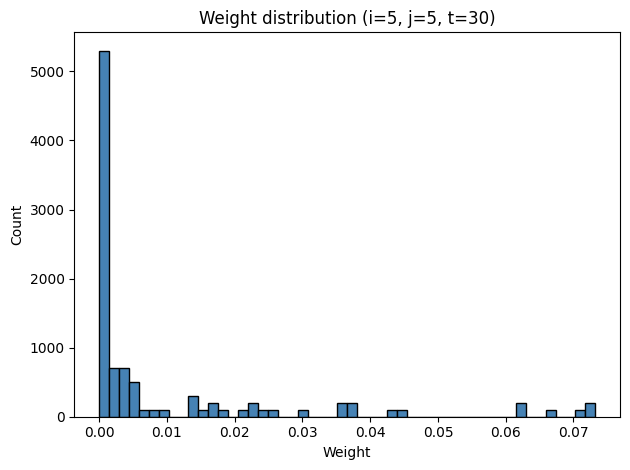

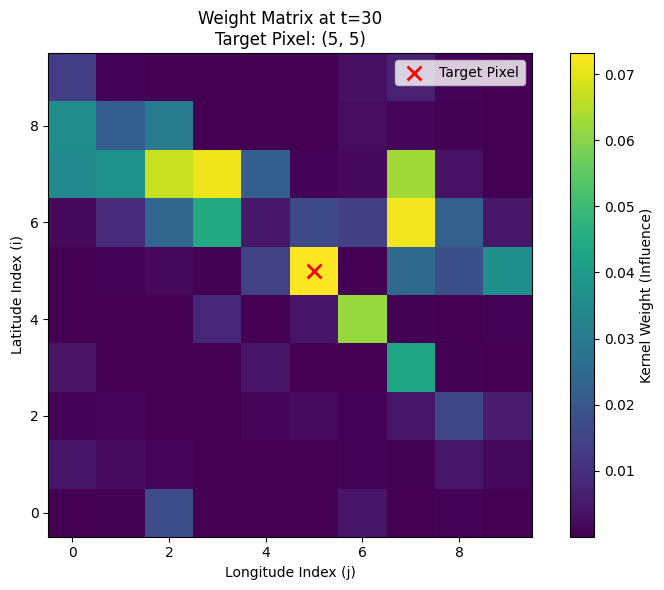

In [89]:
i,j = 5,5
t_idx = 30
weight_adapter = NeuralWeightAdapter(
    net=net, mu_scale=mu_scale, logsig_scale=logsig_scale, xi_scale=xi_scale
)
w_matrix = weight_adapter(
    teacher=teacher, 
    i=i, 
    j=j, 
    t_idx=30, 
    data_shape=data.shape  # (120, 50, 50)
)

w_flat = w_matrix.reshape(-1)
plt.figure()
plt.hist(w_flat, bins=50, color="steelblue", edgecolor="k")
plt.xlabel("Weight"); plt.ylabel("Count")
plt.title(f"Weight distribution (i={i}, j={j}, t={t_idx})")
plt.tight_layout()
plt.show()

def plot_weight_matrix(weights, time_idx=0, target_ij=(5,5)):
    """
    Plots the weight matrix at a given time step.

    Args:
        weights (np.ndarray): Weight matrix of shape (n_time, n_lat, n_lon).
        time_idx (int): The time index t to visualize.
        target_ij (tuple, optional): (i, j) coordinates of the target pixel to mark.
    """
    if time_idx < 0 or time_idx >= weights.shape[0]:
        print(f"Error: Time index {time_idx} out of bounds.")
        return

    # Extract the 2D spatial slice at time t
    w_slice = weights[time_idx]

    plt.figure(figsize=(8, 6))
    
    # Plot heatmap
    # origin='upper' puts (0,0) at top-left, matching matrix indexing (row, col)
    im = plt.imshow(w_slice, cmap='viridis', origin='lower', interpolation='nearest')
    plt.colorbar(im, label='Kernel Weight (Influence)')

    plt.title(f"Weight Matrix at t={time_idx}\nTarget Pixel: {target_ij}")
    plt.xlabel("Longitude Index (j)")
    plt.ylabel("Latitude Index (i)")

    # Mark the target pixel if coordinates are provided
    if target_ij is not None:
        ti, tj = target_ij
        plt.scatter(tj, ti, c='red', marker='x', s=100, linewidth=2, label='Target Pixel')
        plt.legend(loc='upper right')

    plt.tight_layout()
    #plt.savefig(f"weight_matrix_t{time_idx}.png")
    #plt.show() # Uncomment if running locally
plot_weight_matrix(
    weights=w_matrix, 
    time_idx=t_idx, 
    target_ij=(i, j)
)

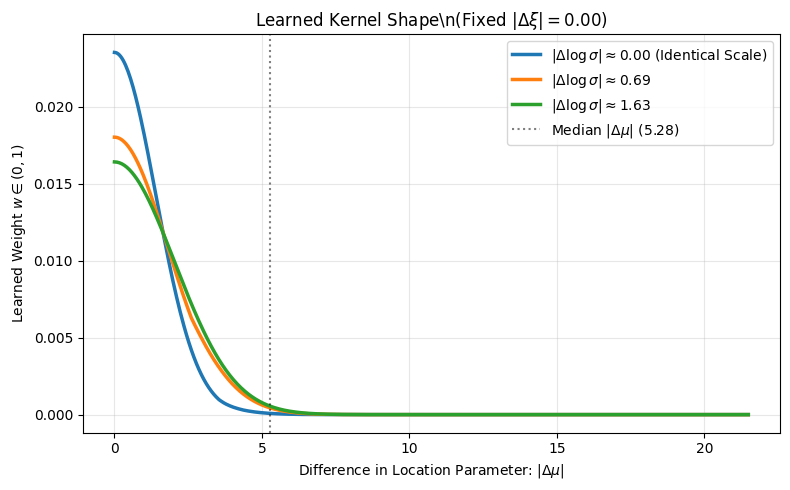

In [24]:
@torch.inference_mode()
def plot_learned_kernel_profile(
    dynamic_net,
    mu_tensor,              # (N,) or (T, S)
    mu_scale,               # scalar (median |Δμ|)
    log_sigma_tensor,       # (N,) or (T, S)
    logsig_scale=None,      # scalar (median |Δlogσ|)
    xi_tensor=None,         # (N,) or (T, S)
    xi_scale=None,          # scalar (median |Δξ|)
    *,
    fixed_dxi="median",     # "0", "median", "p90"
    squared: bool = True,   # Must match training (True in your code)
    num_pairs: int = 100_000,
    delta_logsig_vals="auto"
):
    """
    Visualizes the learned similarity kernel: w(|Δμ|) for different slices of |Δlogσ|.
    Compatible with both Space-Time (flat) and Time-Mode (T, S) tensors.
    """
    dynamic_net.eval()
    device = mu_tensor.device

    # --- 1. Auto-Flatten Inputs (Handles both Networks) ---
    # If input is (T, S), we flatten to (N,) to sample global pairs easily.
    mu_flat  = mu_tensor.reshape(-1)
    ls_flat  = log_sigma_tensor.reshape(-1)
    xi_flat  = xi_tensor.reshape(-1) if xi_tensor is not None else None
    
    N = mu_flat.shape[0]

    # --- 2. Robust Pair Sampling ---
    M = min(num_pairs, max(1, N * (N - 1)))
    # Random pairs (i, j)
    i = torch.randint(0, N, (M,), device=device)
    j = torch.randint(0, N - 1, (M,), device=device)
    j = j + (j >= i).long() # ensure i != j

    # Compute raw absolute differences (matching training logic)
    dmu_raw = torch.abs(mu_flat[i] - mu_flat[j])
    dls_raw = torch.abs(ls_flat[i] - ls_flat[j])

    # --- 3. Define Grid for X-Axis (|Δμ|) ---
    dmax = float(torch.quantile(dmu_raw, 0.99).item()) # Cover 99% of data range
    dgrid = torch.linspace(0.0, dmax, steps=512, device=device)

    # Transform grid to feature space
    if squared:
        f_mu = (dgrid ** 2) / ((mu_scale ** 2) + 1e-8)
    else:
        f_mu = dgrid / (mu_scale + 1e-8)

    # --- 4. Handle Auxiliary Features ---
    if logsig_scale is None:
        logsig_scale = torch.median(dls_raw)
        
    # Resolve fixed |Δξ| value
    if xi_flat is not None:
        dxi_raw_sample = torch.abs(xi_flat[i] - xi_flat[j])
        if xi_scale is None:
            xi_scale = torch.median(dxi_raw_sample)
            
        if isinstance(fixed_dxi, str):
            if fixed_dxi == "median":
                fixed_xi_val = float(torch.quantile(dxi_raw_sample, 0.5).item())
            elif fixed_dxi == "p90":
                fixed_xi_val = float(torch.quantile(dxi_raw_sample, 0.9).item())
            elif fixed_dxi in ["0", "zero"]:
                fixed_xi_val = 0.0
        else:
            fixed_xi_val = float(fixed_dxi)
    else:
        # If no xi provided, assume 0
        fixed_xi_val = 0.0
        if xi_scale is None: xi_scale = 1.0

    # Build constant ξ feature vector
    if squared:
        fxi_scalar = (fixed_xi_val ** 2) / ((xi_scale ** 2) + 1e-8)
    else:
        fxi_scalar = fixed_xi_val / (xi_scale + 1e-8)
    f_xi = torch.full_like(f_mu, fxi_scalar)

    # --- 5. Plotting Loops ---
    # Determine which |Δlogσ| curves to draw
    if isinstance(delta_logsig_vals, str) and delta_logsig_vals == "auto":
        med_dls = float(torch.quantile(dls_raw, 0.50).item())
        p90_dls = float(torch.quantile(dls_raw, 0.90).item())
        slices = [0.0, med_dls, p90_dls]
    else:
        slices = list(delta_logsig_vals) if delta_logsig_vals else [0.0]

    plt.figure(figsize=(8, 5))
    x_np = dgrid.detach().cpu().numpy()

    for dls in slices:
        dls = float(abs(dls))
        
        # Build constant logσ feature vector
        if squared:
            fsig_scalar = (dls ** 2) / ((logsig_scale ** 2) + 1e-8)
        else:
            fsig_scalar = dls / (logsig_scale + 1e-8)
        f_sig = torch.full_like(f_mu, fsig_scalar)

        # Stack [d_μ, d_logσ, d_ξ]
        X = torch.stack([f_mu, f_sig, f_xi], dim=-1) # (512, 3)
        
        # Forward pass
        # Forward pass -> logits -> softmax with same tau
        logits = dynamic_net(X).squeeze(1)
        tau = getattr(dynamic_net, "tau", 1.0)
        w = torch.softmax(logits / tau, dim=0).cpu().numpy()

        label_str = rf'$|\Delta \log \sigma| \approx {dls:.2f}$'
        if dls == 0: label_str += " (Identical Scale)"
        
        plt.plot(x_np, w, lw=2.5, label=label_str)

    # Add context to plot
    plt.axvline(x=float(mu_scale), color='k', linestyle=':', alpha=0.5, label=rf'Median $|\Delta \mu|$ ({mu_scale:.2f})')
    
    plt.xlabel(r'Difference in Location Parameter: $|\Delta \mu|$')
    plt.ylabel(r'Learned Weight $w \in (0,1)$')
    plt.title(rf'Learned Kernel Shape\n(Fixed $|\Delta \xi| = {fixed_xi_val:.2f}$)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    
plot_learned_kernel_profile(
    dynamic_net=net,              # The trained network from Script 2
    mu_tensor=mu_train,         # (T, S)
    mu_scale=mu_scale,            # The scalar used in Script 2
    log_sigma_tensor=lsig_train,
    logsig_scale=logsig_scale,
    xi_tensor=xi_train,
    xi_scale=xi_scale,
    fixed_dxi="0",
    squared=True
)

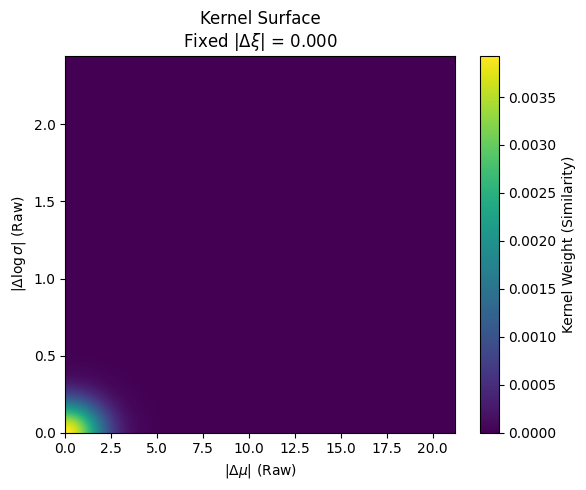

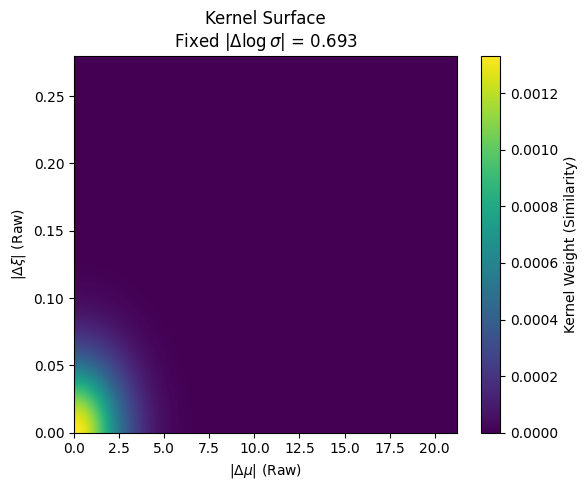

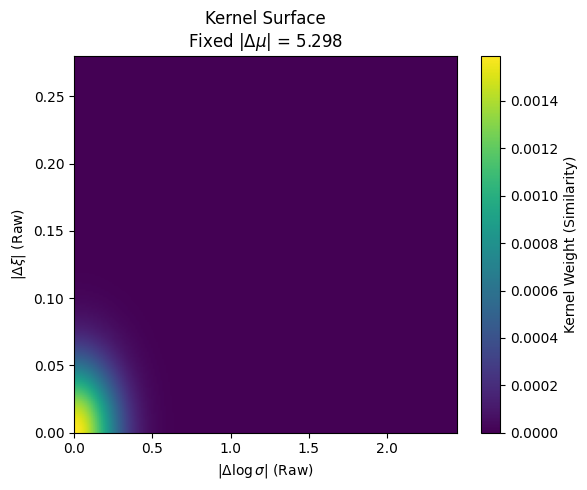

In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt

@torch.inference_mode()
def plot_kernel_heatmap(
    dynamic_net,
    *,
    # --- Generic Input Tensors (N,) or (T, S) ---
    mu_tensor=None,          
    log_sigma_tensor=None,   
    xi_tensor=None,          
    
    # --- Robust Scales (Optional: Auto-computed if None) ---
    mu_scale=None,
    logsig_scale=None,
    xi_scale=None,
    
    # --- Configuration ---
    x_axis: str = "mu",        # "mu", "logsigma", or "xi"
    y_axis: str = "xi",        # "mu", "logsigma", or "xi"
    fixed: dict = None,        # e.g., {"logsigma": "zero"} or {"mu": "median"}
    
    # --- Visualization Settings ---
    squared: bool = True,      # Must match training (True for your kernels)
    num_pairs: int = 200_000,
    nx: int = 200,             # Resolution X
    ny: int = 200              # Resolution Y
):
    """
    Generates a 2D Heatmap of the learned kernel weight w(x, y).
    
    1. Flattens all inputs to handle both Space-Time (N,) and Time-Mode (T, S) data.
    2. Varies x_axis and y_axis over the 99th percentile range of absolute differences found in data.
    3. Holds the third variable constant (based on 'fixed' dict).
    """
    dynamic_net.eval()
    
    # --- 1. Standardization & Flattening ---
    # We flatten everything to (N,) so we can sample random pairs easily
    # regardless of whether the input was (T, S) or (N,).
    
    def prep(t): return t.reshape(-1) if t is not None else None
    
    mu_flat  = prep(mu_tensor)
    ls_flat  = prep(log_sigma_tensor)
    xi_flat  = prep(xi_tensor)
    
    # Determine device and valid N
    device = next(dynamic_net.parameters()).device
    N = 0
    for t in (mu_flat, ls_flat, xi_flat):
        if t is not None:
            N = t.shape[0]
            device = t.device
            break
            
    if N == 0: raise ValueError("No data tensors provided.")

    # --- 2. Helper: Need-Check ---
    def _check_avail(name):
        if name == "mu" and mu_flat is None: raise ValueError("mu_tensor required.")
        if name == "logsigma" and ls_flat is None: raise ValueError("log_sigma_tensor required.")
        if name == "xi" and xi_flat is None: raise ValueError("xi_tensor required.")

    x_axis, y_axis = x_axis.lower(), y_axis.lower()
    axes_set = {"mu", "logsigma", "xi"}
    if x_axis == y_axis: raise ValueError("x_axis and y_axis must be different.")
    
    # Identify the third variable that is fixed
    fixed_var = list(axes_set - {x_axis, y_axis})[0]
    
    _check_avail(x_axis); _check_avail(y_axis); _check_avail(fixed_var)

    # --- 3. Sampling for Ranges ---
    M = min(num_pairs, max(1, N*(N-1)))
    i = torch.randint(0, N, (M,), device=device)
    j = torch.randint(0, N-1, (M,), device=device)
    j = j + (j >= i).long()

    def get_raw_delta(name, idx_i, idx_j):
        if name == "mu": return torch.abs(mu_flat[idx_i] - mu_flat[idx_j])
        if name == "logsigma": return torch.abs(ls_flat[idx_i] - ls_flat[idx_j])
        if name == "xi": return torch.abs(xi_flat[idx_i] - xi_flat[idx_j])
    
    # Compute 99th percentile max ranges for axes
    x_deltas = get_raw_delta(x_axis, i, j)
    y_deltas = get_raw_delta(y_axis, i, j)
    x_max = float(torch.quantile(x_deltas, 0.99).item())
    y_max = float(torch.quantile(y_deltas, 0.99).item())

    # --- 4. Resolve Fixed Value ---
    # Default to "zero" (ideal match) if not specified
    if fixed is None: fixed = {}
    fix_spec = fixed.get(fixed_var, "zero") 
    
    def resolve_fixed_val(spec, name):
        if isinstance(spec, (float, int)): return float(spec)
        spec = str(spec).lower()
        if spec in ["0", "zero", "0.0"]: return 0.0
        
        # We need data to compute stats
        d = get_raw_delta(name, i, j)
        if spec == "median": return float(torch.quantile(d, 0.50).item())
        if spec in ["p90", "90"]: return float(torch.quantile(d, 0.90).item())
        raise ValueError(f"Unknown fixed spec: {spec}")

    fixed_raw_val = resolve_fixed_val(fix_spec, fixed_var)

    # --- 5. Scaling (Auto-compute if missing) ---
    # Helper to get scale safely
    def get_scale(name, provided_scale, tensor_flat):
        if provided_scale is not None: return provided_scale
        # Compute median absolute difference
        # (This mimics estimate_global_dist_scale logic on 1D data)
        # We reuse the sampled pairs i,j for speed
        diffs = torch.abs(tensor_flat[i] - tensor_flat[j])
        return torch.median(diffs)

    s_mu  = get_scale("mu", mu_scale, mu_flat)
    s_ls  = get_scale("logsigma", logsig_scale, ls_flat)
    s_xi  = get_scale("xi", xi_scale, xi_flat)
    
    scale_map = {"mu": s_mu, "logsigma": s_ls, "xi": s_xi}

    # --- 6. Build Grid & Features ---
    # Create grid in RAW units
    gx = torch.linspace(0.0, x_max, steps=nx, device=device)
    gy = torch.linspace(0.0, y_max, steps=ny, device=device)
    GY, GX = torch.meshgrid(gy, gx, indexing='ij') # (ny, nx)

    def raw_to_feature(raw_grid, name):
        s = scale_map[name]
        if squared:
            return (raw_grid ** 2) / ((s ** 2) + 1e-8)
        return raw_grid / (s + 1e-8)

    # Initialize feature maps
    feats = {}
    
    # Fill X and Y features
    feats[x_axis] = raw_to_feature(GX, x_axis)
    feats[y_axis] = raw_to_feature(GY, y_axis)
    
    # Fill Fixed feature (constant plane)
    fixed_feat_scalar = raw_to_feature(torch.tensor(fixed_raw_val, device=device), fixed_var)
    feats[fixed_var] = torch.full_like(GX, fixed_feat_scalar)

    # Stack in strict order: [mu, logsigma, xi]
    X_in = torch.stack([
        feats["mu"], 
        feats["logsigma"], 
        feats["xi"]
    ], dim=-1).reshape(-1, 3)

    # --- 7. Forward Pass (logits -> weights with tau) ---
    logits = dynamic_net(X_in).reshape(-1)
    tau = getattr(dynamic_net, "tau", 1.0)
    W = torch.softmax(logits / tau, dim=0).reshape(ny, nx).cpu().numpy()

    # --- 8. Plot ---
    labels = {
        "mu": r"$|\Delta \mu|$",
        "logsigma": r"$|\Delta \log \sigma|$",
        "xi": r"$|\Delta \xi|$"
    }
    
    plt.figure(figsize=(6, 5))
    extent = [0.0, x_max, 0.0, y_max]
    
    plt.imshow(W, origin='lower', aspect='auto', extent=extent, cmap='viridis')
    cbar = plt.colorbar()
    cbar.set_label("Kernel Weight (Similarity)")
    
    plt.xlabel(f"{labels[x_axis]} (Raw)")
    plt.ylabel(f"{labels[y_axis]} (Raw)")
    plt.title(f"Kernel Surface\nFixed {labels[fixed_var]} = {fixed_raw_val:.3f}")
    plt.tight_layout()
    plt.show()

# 2. Heatmap: Mu vs LogSigma (Fixing Xi at Median)
# This shows if the network cares about scale differences when means are similar
plot_kernel_heatmap(
    net,
    mu_tensor=mu_train,           # (T, S)
    log_sigma_tensor=lsig_train,
    xi_tensor=xi_train,
    mu_scale=mu_scale,
    logsig_scale=logsig_scale,
    xi_scale=xi_scale,
    x_axis="mu", 
    y_axis="logsigma", 
    fixed={"xi": "0"},         # Slice through the "average" Xi difference
    squared=True
)
plot_kernel_heatmap(
    net,
    mu_tensor=mu_train,           # (T, S)
    log_sigma_tensor=lsig_train,
    xi_tensor=xi_train,
    mu_scale=mu_scale,
    logsig_scale=logsig_scale,
    xi_scale=xi_scale,
    x_axis="mu", 
    y_axis="xi", 
    fixed={"logsigma": "median"},         # Slice through the "average" Xi difference
    squared=True
)
plot_kernel_heatmap(
    net,
    mu_tensor=mu_train,           # (T, S)
    log_sigma_tensor=lsig_train,
    xi_tensor=xi_train,
    mu_scale=mu_scale,
    logsig_scale=logsig_scale,
    xi_scale=xi_scale,
    x_axis="logsigma", 
    y_axis="xi", 
    fixed={"mu": "median"},         # Slice through the "average" Xi difference
    squared=True
)

In [ ]:
from matplotlib.animation import FuncAnimation

# ---------- small helper ----------
def _extent_from_meta(meta):
    if meta is not None and "x" in meta and "y" in meta:
        x = np.asarray(meta["x"]); y = np.asarray(meta["y"])
        return (x.min(), x.max(), y.min(), y.max())
    return None

@torch.inference_mode()
def _weight_map_from_mu_frame(dynamic_net, mu_frame_np, mu_q_scalar, dist_scale,
                              squared: bool = True, device=None,
                              lat_stride: int = 1, lon_stride: int = 1,
                              roi: tuple | None = None,  # (i_start, i_end, j_start, j_end)
                              use_fp16: bool = False):
    """
    One frame: spatial weights at a fixed time given a query μ.
    Returns (H',W') numpy map after ROI+stride.
    """
    if device is None:
        device = next(dynamic_net.parameters()).device

    if roi is not None:
        i0, i1, j0, j1 = roi
        mu_frame_np = mu_frame_np[i0:i1, j0:j1]
    mu_frame_np = mu_frame_np[::lat_stride, ::lon_stride]

    dtype = torch.float16 if (use_fp16 and device.type == "cuda") else torch.float32
    mu_frame = torch.from_numpy(mu_frame_np.astype(np.float32)).to(device=device, dtype=dtype)
    mu_q = torch.tensor(float(mu_q_scalar), device=device, dtype=dtype)

    d = torch.abs(mu_frame - mu_q)             # |Δμ|
    if squared:
        d = (d ** 2) / ((dist_scale ** 2) + 1e-8)
    else:
        d = d / (dist_scale + 1e-8)

    W = dynamic_net(d.reshape(-1, 1)).reshape_as(mu_frame)
    return W.detach().float().cpu().numpy()


# ======================= 1) 1D plot — fixed (i0,j0), ref time moves =======================
@torch.inference_mode()
def animate_temporal_1d_for_pixel(dynamic_net, mu_hat, dist_scale,
                                  i0: int, j0: int,
                                  squared: bool = True,
                                  t_step: int = 1, max_frames: int | None = None,
                                  fps: int = 10, save_path: str | None = None):
    """
    For pixel (i0,j0), show weights vs *all times*; the reference time moves across frames.
    """
    dynamic_net.eval()
    device = next(dynamic_net.parameters()).device
    mu_line = mu_hat[:, i0, j0].astype(np.float32)  # (T,)
    T = mu_line.shape[0]

    t_list = list(range(0, T, t_step))
    if max_frames is not None:
        t_list = t_list[:max_frames]

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.set_xlim(0, T-1); ax.set_ylim(0, 1)
    ax.set_xlabel("time index"); ax.set_ylabel("kernel weight")
    ax.grid(True, alpha=0.3)
    title = ax.set_title("")
    line, = ax.plot([], [], lw=2)
    marker = ax.scatter([], [], c="red", s=80, zorder=5)

    # prebuild torch tensor holder to avoid realloc per frame
    x_torch = torch.empty((T, 1), device=device, dtype=torch.float32)

    def _weights_for_ref(t_ref: int):
        # distances across time against the reference μ at this pixel
        d = np.abs(mu_line - mu_line[t_ref])
        if squared:
            x = (d ** 2) / ((float(dist_scale) ** 2) + 1e-8)
        else:
            x = d / (float(dist_scale) + 1e-8)
        x_torch[:, 0] = torch.from_numpy(x.astype(np.float32)).to(device)
        w = dynamic_net(x_torch).squeeze(1).detach().cpu().numpy()
        return w

    def _update(fi):
        t_ref = t_list[fi]
        w = _weights_for_ref(t_ref)
        line.set_data(np.arange(T), w)
        marker.set_offsets([t_ref, w[t_ref]])
        title.set_text(f"Temporal weights at (i={i0}, j={j0}) — ref t={t_ref}")
        return line, marker, title

    anim = FuncAnimation(fig, _update, frames=len(t_list),
                         interval=int(1000/fps), blit=False)
    plt.close(fig)
    if save_path:
        anim.save(save_path, writer="pillow", fps=fps)
        print(f"saved temporal 1D animation → {save_path}")
    return anim


# ======================= 2) 2D plot — fixed t0, ref pixel moves in space =======================
@torch.inference_mode()
def animate_spatial_2d_for_time(dynamic_net, mu_hat, dist_scale,
                                t0: int,
                                meta=None,
                                squared: bool = True,
                                lat_stride: int = 1, lon_stride: int = 1,
                                roi: tuple | None = None,      # (i_start,i_end,j_start,j_end)
                                path: str = "scan",            # "scan" (serpentine) or "random"
                                max_frames: int | None = None,
                                fps: int = 10,
                                vmax_quantile: float = 0.99,
                                use_fp16: bool = False,
                                save_path: str | None = None):
    """
    At fixed time t0, move the reference pixel across space; each frame shows a spatial weight heatmap.
    """
    dynamic_net.eval()
    T, H, W = mu_hat.shape
    extent = _extent_from_meta(meta)

    # build traversal order over (i,j)
    if path == "random":
        order = np.column_stack([
            np.random.randint(0, H, size=H*W),
            np.random.randint(0, W, size=H*W)
        ])
    else:  # serpentine scan with strides
        order = []
        for i in range(0, H, lat_stride):
            cols = list(range(0, W, lon_stride)) if (i // lat_stride) % 2 == 0 \
                   else list(range(W-1, -1, -lon_stride))
            for j in cols:
                order.append((i, j))
        order = np.array(order, dtype=int)

    if max_frames is not None:
        order = order[:max_frames]

    # probe some frames to set a stable vmax
    probe_idx = np.linspace(0, len(order)-1, num=min(40, len(order)), dtype=int)
    probe_vals = []
    for idx in probe_idx:
        i, j = order[idx]
        mu_q = float(mu_hat[t0, i, j])
        w = _weight_map_from_mu_frame(dynamic_net, mu_hat[t0], mu_q, dist_scale,
                                      squared=squared, lat_stride=lat_stride, lon_stride=lon_stride,
                                      roi=roi, use_fp16=use_fp16)
        probe_vals.append(w)
    vmax = float(np.quantile(np.array(probe_vals).ravel(), vmax_quantile)) if probe_vals else 1.0

    # determine displayed shape after ROI+stride
    if roi is None:
        Hs, Ws = H, W
    else:
        Hs, Ws = roi[1]-roi[0], roi[3]-roi[2]
    Hs = (Hs + lat_stride - 1) // lat_stride
    Ws = (Ws + lon_stride - 1) // lon_stride

    fig, ax = plt.subplots(figsize=(7,5))
    im = ax.imshow(np.zeros((Hs, Ws)), origin="lower", extent=extent, aspect="auto",
                   vmin=0, vmax=vmax, cmap="viridis", interpolation="none")
    fig.colorbar(im, ax=ax, label="kernel weight")
    ref_scatter = ax.scatter([], [], s=150, c="red", marker="*", edgecolor="black", zorder=5)
    title = ax.set_title("")

    def _update(fi):
        i, j = order[fi]
        mu_q = float(mu_hat[t0, i, j])
        w = _weight_map_from_mu_frame(dynamic_net, mu_hat[t0], mu_q, dist_scale,
                                      squared=squared, lat_stride=lat_stride, lon_stride=lon_stride,
                                      roi=roi, use_fp16=use_fp16)
        im.set_data(w)
        # update reference marker
        if extent is None:
            # image pixel coords (account for ROI/stride)
            ii = (i - (roi[0] if roi else 0)) // lat_stride
            jj = (j - (roi[2] if roi else 0)) // lon_stride
            ref_scatter.set_offsets([jj, ii])
        else:
            ref_scatter.set_offsets([float(meta["x"][j]), float(meta["y"][i])])
        title.set_text(f"Spatial weights — fixed t={t0}, ref=(i={i}, j={j})")
        return im, ref_scatter, title

    anim = FuncAnimation(fig, _update, frames=len(order),
                         interval=int(1000/fps), blit=False)
    plt.close(fig)
    if save_path:
        anim.save(save_path, writer="pillow", fps=fps)
        print(f"saved spatial 2D animation → {save_path}")
    return anim


In [56]:
from pathlib import Path
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# make EVT_Classes importable from SIM/
current_dir = Path.cwd().resolve()
evt_classes_dir = current_dir.parent
if str(evt_classes_dir) not in sys.path:
    sys.path.insert(0, str(evt_classes_dir))

from selector import select_spatial_neighborhood

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float64)

# data must already exist: shape (T,H,W)
T, H, W = data.shape
S = H * W

Y_np = data.reshape(T, S).astype(np.float64)
Y = torch.from_numpy(Y_np).to(device)

# Selector config (change here)
selector_args = {
    "mode": "circle",      # "square" or "circle"
    "radius": None,        # None => full-grid fallback
    "max_points": 100,      # direct control
    "include_center": True
}

def build_neighbor_tables(n_lat, n_lon, selector_args, device):
    s_total = n_lat * n_lon
    idx_list, d2_list = [], []

    for s in range(s_total):
        i0, j0 = divmod(s, n_lon)
        sel = select_spatial_neighborhood(
            n_lat=n_lat,
            n_lon=n_lon,
            i=i0,
            j=j0,
            mode=selector_args["mode"],
            radius=selector_args["radius"],
            max_points=selector_args["max_points"],
            include_center=selector_args["include_center"],
        )

        flat = sel.flat_idx.astype(np.int64)
        if flat.size == 0:
            flat = np.array([s], dtype=np.int64)  # safe fallback

        ii = flat // n_lon
        jj = flat % n_lon
        d2 = ((ii - i0) ** 2 + (jj - j0) ** 2).astype(np.float64)

        idx_list.append(flat)
        d2_list.append(d2)

    k_max = max(len(x) for x in idx_list)

    nbr_idx = np.zeros((s_total, k_max), dtype=np.int64)
    nbr_d2 = np.zeros((s_total, k_max), dtype=np.float64)
    nbr_mask = np.zeros((s_total, k_max), dtype=bool)

    for s, (fi, fd2) in enumerate(zip(idx_list, d2_list)):
        k = len(fi)
        nbr_idx[s, :k] = fi
        nbr_d2[s, :k] = fd2
        nbr_mask[s, :k] = True
        if k < k_max:
            nbr_idx[s, k:] = fi[0]
            nbr_d2[s, k:] = fd2[0]

    return (
        torch.tensor(nbr_idx, dtype=torch.long, device=device),
        torch.tensor(nbr_d2, dtype=torch.float64, device=device),
        torch.tensor(nbr_mask, dtype=torch.bool, device=device),
    )

nbr_idx, nbr_d2, nbr_mask = build_neighbor_tables(H, W, selector_args, device)
print("Neighbor table shapes:", nbr_idx.shape, nbr_d2.shape, nbr_mask.shape)


Neighbor table shapes: torch.Size([100, 100]) torch.Size([100, 100]) torch.Size([100, 100])


In [57]:
# Cell B (replacement) - Joint model with simple Gaussian 2-distance kernel
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

def inv_softplus_np(x):
    x = np.asarray(x, dtype=np.float64)
    x = np.maximum(x, 1e-12)
    return np.log(np.expm1(x) + 1e-12)

def robust_pair_scale_1d(v, num_pairs=200_000, seed=2025):
    v = np.asarray(v, dtype=np.float64).reshape(-1)
    n = v.size
    if n < 2:
        return 1.0
    m = min(num_pairs, max(1, n * (n - 1)))
    rng = np.random.default_rng(seed)
    i = rng.integers(0, n, size=m)
    j = rng.integers(0, n - 1, size=m)
    j = j + (j >= i)
    d = np.abs(v[i] - v[j])
    return float(np.median(d)) + 1e-8

class Gaussian2DJointGEV(nn.Module):
    """
    Joint learning of:
      - per-site theta: mu_s, sigma_s, xi_s
      - kernel bandwidths: h_space, h_mu
    Kernel:
      logits_ij = -0.5 * ( (d_space_ij^2 / dist_scale2)/h_space^2 + (d_mu_ij^2 / mu_scale2)/h_mu^2 )
      w_ij = softmax_j(logits_ij) over selected neighbors
    """
    def __init__(
        self,
        y_ts_np,
        h_space_init=100.0,
        h_mu_init=100.0,
        xi_bound=0.35,
        sigma_min=1e-4,
        h_min=1e-4,
        xi_init=0.02
    ):
        super().__init__()
        mu0 = np.mean(y_ts_np, axis=0)
        sig0 = np.std(y_ts_np, axis=0, ddof=1)
        sig0 = np.clip(sig0, 1e-3, None)

        self.mu = nn.Parameter(torch.tensor(mu0, dtype=torch.float64))
        self.raw_sigma = nn.Parameter(torch.tensor(inv_softplus_np(sig0), dtype=torch.float64))
        xi0 = float(np.clip(xi_init, -0.95 * xi_bound, 0.95 * xi_bound))
        raw_xi0 = np.arctanh(xi0 / xi_bound)
        self.raw_xi = nn.Parameter(torch.full_like(self.mu, raw_xi0))

        self.raw_h_space = nn.Parameter(torch.tensor(inv_softplus_np(np.array(h_space_init, dtype=np.float64)), dtype=torch.float64))
        self.raw_h_mu = nn.Parameter(torch.tensor(inv_softplus_np(np.array(h_mu_init, dtype=np.float64)), dtype=torch.float64))

        self.xi_bound = float(xi_bound)
        self.sigma_min = float(sigma_min)
        self.h_min = float(h_min)

    def constrained(self):
        sigma = F.softplus(self.raw_sigma) + self.sigma_min
        xi = self.xi_bound * torch.tanh(self.raw_xi)
        h_space = F.softplus(self.raw_h_space) + self.h_min
        h_mu = F.softplus(self.raw_h_mu) + self.h_min
        return self.mu, sigma, xi, h_space, h_mu


def joint_batch_nll_gauss2(
    model,
    Y_ts,          # (T,S)
    q_idx,         # (B,)
    nbr_idx,       # (S,K)
    nbr_d2,        # (S,K)
    nbr_mask,      # (S,K) bool
    dist_scale2,   # scalar
    mu_scale2,     # scalar
    xi_eps=1e-6,
    penalty=1e6,
):
    mu_all, sigma_all, xi_all, h_space, h_mu = model.constrained()

    idx = nbr_idx[q_idx]      # (B,K)
    d2 = nbr_d2[q_idx]        # (B,K)
    mask = nbr_mask[q_idx]    # (B,K)

    mu_q = mu_all[q_idx].unsqueeze(1)   # (B,1)
    mu_n = mu_all[idx]                  # (B,K)
    dmu2 = (mu_n - mu_q) ** 2

    x_space = d2 / dist_scale2
    x_mu = dmu2 / mu_scale2

    logits = -0.5 * (
        x_space / (h_space * h_space + 1e-12) +
        x_mu / (h_mu * h_mu + 1e-12)
    )
    logits = logits.masked_fill(~mask, -1e9)

    w = torch.softmax(logits, dim=1)
    w = w * mask
    w = w / w.sum(dim=1, keepdim=True).clamp_min(1e-12)

    # Likelihood under target-site theta(q)
    y_tbk = Y_ts[:, idx]  # (T,B,K)

    sigma_q = sigma_all[q_idx]  # (B,)
    xi_q = xi_all[q_idx]        # (B,)

    mu3 = mu_q[None, :, :]                 # (1,B,1)
    sg3 = sigma_q[None, :, None]           # (1,B,1)
    xi3 = xi_q[None, :, None]              # (1,B,1)

    z = (y_tbk - mu3) / sg3
    nll_g = torch.log(sg3) + z + torch.exp(torch.clamp(-z, max=40.0))

    xi_safe = xi_q + xi_eps * torch.tanh(xi_q / xi_eps)
    xi_safe3 = xi_safe[None, :, None]

    t = 1.0 + xi_safe3 * z
    valid = t > 0.0
    log_t = torch.log(torch.clamp(t, min=1e-12))
    pow_term = torch.exp(torch.clamp(-log_t / xi_safe3, min=-40.0, max=40.0))
    nll_gev = torch.log(sg3) + (1.0 + 1.0 / xi_safe3) * log_t + pow_term
    nll_gev = torch.where(valid, nll_gev, torch.full_like(nll_gev, penalty))

    # Always use smooth GEV branch in training so xi keeps non-zero gradients
    nll = nll_gev  # (T,B,K)

    row_nll = (w[None, :, :] * nll).sum(dim=2)  # (T,B)
    nll_mean = row_nll.mean()

    ess = 1.0 / (w.pow(2).sum(dim=1) + 1e-12)
    return nll_mean, ess, w, (h_space, h_mu)


ep=001 train_nll=4.57543 train_loss=4.57563 val_nll=4.57644 h_space=0.9969 h_mu=0.9969 ESS=61.83 |xi|mean=1.9895e-02 RMSE=nan Cov=nan% Width=nan
ep=010 train_nll=4.57166 train_loss=4.57187 val_nll=4.57275 h_space=0.9688 h_mu=0.9688 ESS=60.18 |xi|mean=1.9931e-02 RMSE=nan Cov=nan% Width=nan
ep=020 train_nll=4.56793 train_loss=4.56815 val_nll=4.56910 h_space=0.9383 h_mu=0.9382 ESS=58.31 |xi|mean=2.7119e-02 RMSE=nan Cov=nan% Width=nan
ep=030 train_nll=4.56450 train_loss=4.56474 val_nll=4.56577 h_space=0.9085 h_mu=0.9084 ESS=56.42 |xi|mean=3.2227e-02 RMSE=nan Cov=nan% Width=nan
ep=040 train_nll=4.56127 train_loss=4.56152 val_nll=4.56266 h_space=0.8797 h_mu=0.8795 ESS=54.53 |xi|mean=3.5237e-02 RMSE=nan Cov=nan% Width=nan
ep=050 train_nll=4.55816 train_loss=4.55844 val_nll=4.55968 h_space=0.8518 h_mu=0.8515 ESS=52.64 |xi|mean=3.6749e-02 RMSE=nan Cov=nan% Width=nan
ep=060 train_nll=4.55516 train_loss=4.55545 val_nll=4.55680 h_space=0.8248 h_mu=0.8245 ESS=50.76 |xi|mean=3.7999e-02 RMSE=nan Cov=

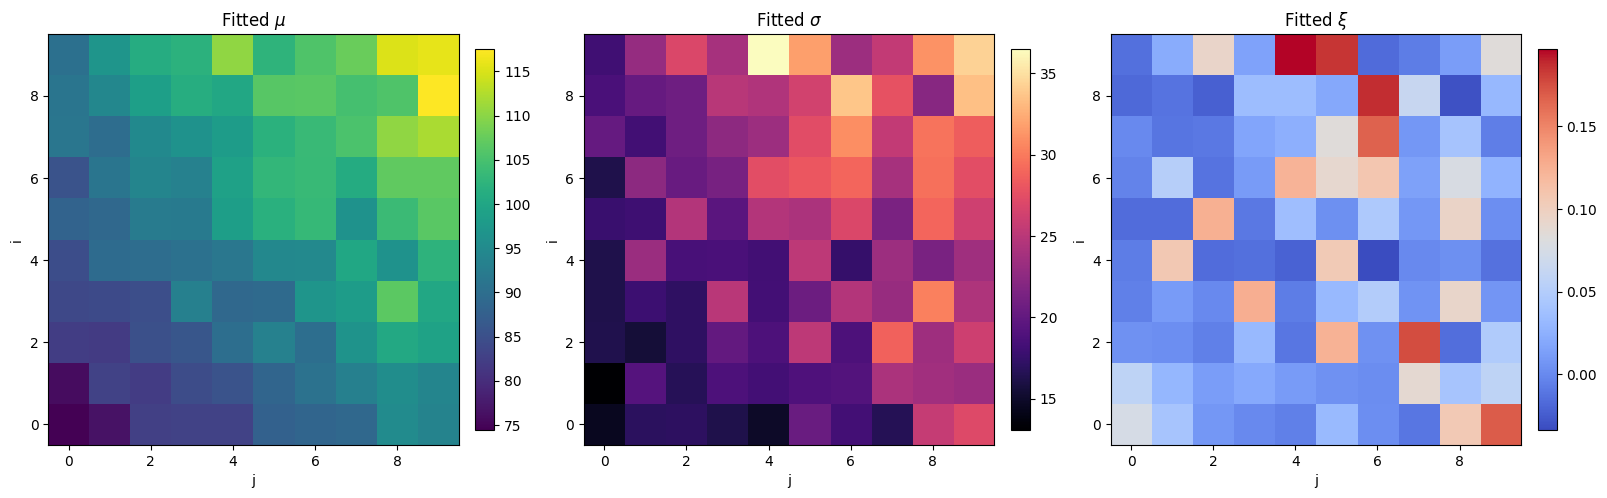

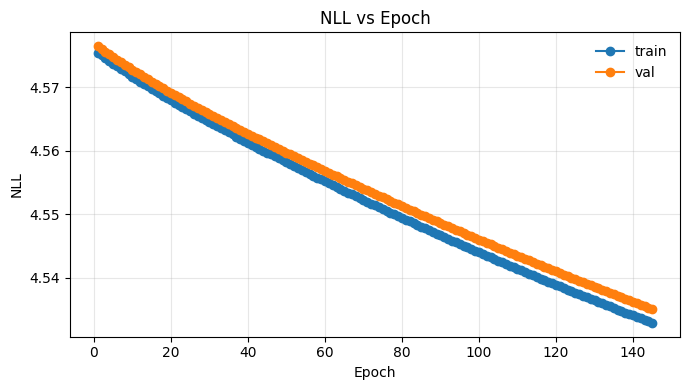

In [ ]:
# Cell C (replacement) - Joint training loop for Gaussian2D kernel
torch.set_default_dtype(torch.float64)

# scales for distance features
d2_valid = nbr_d2[nbr_mask]
d2_pos = d2_valid[d2_valid > 0]
dist_scale2 = float(torch.median(d2_pos).item()) if d2_pos.numel() > 0 else 1.0
dist_scale2 = max(dist_scale2, 1e-8)

mu_init_np = np.mean(Y_np, axis=0)
mu_scale = robust_pair_scale_1d(mu_init_np, num_pairs=200_000, seed=2025)
mu_scale2 = max(mu_scale ** 2, 1e-8)

# time split
rng = np.random.default_rng(2025)
all_t = np.arange(T)
rng.shuffle(all_t)
n_train_t = max(2, int(0.8 * T))
tr_t = torch.tensor(np.sort(all_t[:n_train_t]), dtype=torch.long, device=device)
va_t = torch.tensor(np.sort(all_t[n_train_t:]), dtype=torch.long, device=device)

Y_tr = Y.index_select(0, tr_t)
Y_va = Y.index_select(0, va_t) if va_t.numel() > 0 else Y_tr

model = Gaussian2DJointGEV(
    y_ts_np=Y_np,
    h_space_init=1,   # tune if needed
    h_mu_init=1,      # tune if needed
    xi_bound=0.35,
    sigma_min=1e-4,
    h_min=1e-4,
    xi_init=0.02
).to(device).double()

opt = torch.optim.Adam(model.parameters(), lr=5e-3)

epochs = 145
batch_sites = min(100, S)
val_sites = min(256, S)
patience = 10000

lambda_xi = 1e-6
lambda_h = 1e-4
lambda_ess = 1e-3
ess_target = 9  # set to what you want

hist = {
    "train_nll": [], "train_loss": [], "val_nll": [],
    "h_space": [], "h_mu": [], "mean_ess": []
}


# --- Simulation-validation config (old-network style metrics) ---
DO_SIM_VALIDATION = False
SIM_EVERY = 35         # run compute_combined_sim every N epochs
N_VAL_RUNS = 10
TEST_I, TEST_J = 4,4
TEST_T_IDX = 30
TEST_RETURN_T = 100

# Choose what metric family to track:
# "return_levels" with key str(TEST_RETURN_T), OR "gev_params" with key "u0"/"sigma0"/"xi0"
TRACK_SOURCE = "return_levels"
TRACK_KEY = str(TEST_RETURN_T) if TRACK_SOURCE == "return_levels" else "u0"

hist.update({"rmse": [], "cov": [], "width": []})

def _extract_sim_metrics(sim_out, source, key):
    m = sim_out[source][key]
    return float(m["rmse"]), float(m["coverage_prob"]), float(m["mean_ci_width"])



best_val = float("inf")
best_state = None
wait = 0

for ep in range(1, epochs + 1):
    model.train()
    perm = torch.randperm(S, device=device)

    ep_nll = 0.0
    ep_loss = 0.0
    ep_ess = 0.0
    nb = 0

    for s0 in range(0, S, batch_sites):
        q_idx = perm[s0:s0 + batch_sites]
        if q_idx.numel() == 0:
            continue

        nll, ess, _, (h_space_now, h_mu_now) = joint_batch_nll_gauss2(
            model=model,
            Y_ts=Y_tr,
            q_idx=q_idx,
            nbr_idx=nbr_idx,
            nbr_d2=nbr_d2,
            nbr_mask=nbr_mask,
            dist_scale2=dist_scale2,
            mu_scale2=mu_scale2,
        )

        _, _, xi_all, h_space_all, h_mu_all = model.constrained()
        reg_xi = lambda_xi * torch.mean((xi_all / model.xi_bound) ** 2)
        reg_h = lambda_h * (1.0 / (h_space_all * h_space_all) + 1.0 / (h_mu_all * h_mu_all))
        reg_ess = lambda_ess * torch.mean(torch.relu(torch.tensor(ess_target, device=device) - ess) ** 2)

        loss = nll + reg_xi + reg_h 

        opt.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        opt.step()

        ep_nll += float(nll.detach().cpu())
        ep_loss += float(loss.detach().cpu())
        ep_ess += float(ess.mean().detach().cpu())
        nb += 1

    train_nll = ep_nll / max(1, nb)
    train_loss = ep_loss / max(1, nb)
    mean_ess = ep_ess / max(1, nb)

    model.eval()
    with torch.no_grad():
        qv = torch.randperm(S, device=device)[:val_sites]
        val_nll, _, _, (h_space_val, h_mu_val) = joint_batch_nll_gauss2(
            model=model,
            Y_ts=Y_va,
            q_idx=qv,
            nbr_idx=nbr_idx,
            nbr_d2=nbr_d2,
            nbr_mask=nbr_mask,
            dist_scale2=dist_scale2,
            mu_scale2=mu_scale2,
        )
        val_nll = float(val_nll.detach().cpu())
        h_space_val = float(h_space_val.detach().cpu())
        h_mu_val = float(h_mu_val.detach().cpu())
        
    
    
    # --- Decoupled simulation validation (same spirit as old network) ---
    rmse_val = cov_val = width_val = float("nan")

    if DO_SIM_VALIDATION and (ep == 1 or ep % SIM_EVERY == 0):
        # requires Gaussian2DWeightAdapter class to be defined before this cell
        epoch_adapter = Gaussian2DWeightAdapter(
            trained_model=model,
            dist_scale2=dist_scale2,
            mu_scale2=mu_scale2,
            device=device,
        )

        sim_out = compute_combined_sim(
            generate_fn=generate_gev_dataset_linear,
            gen_kwargs=gen_kwargs,
            i=TEST_I, j=TEST_J,
            n_runs=N_VAL_RUNS,
            return_periods=[TEST_RETURN_T],
            t_idx=TEST_T_IDX,
            n_jobs_runs=-1,
            backend="threading",
            verbose=False,
            fit_mode="full",
            weights=epoch_adapter,
        )

        rmse_val, cov_val, width_val = _extract_sim_metrics(sim_out, TRACK_SOURCE, TRACK_KEY)

    elif hist["rmse"]:
        # hold last value between validation checkpoints
        rmse_val, cov_val, width_val = hist["rmse"][-1], hist["cov"][-1], hist["width"][-1]

    hist["rmse"].append(rmse_val)
    hist["cov"].append(cov_val)
    hist["width"].append(width_val)



    hist["train_nll"].append(train_nll)
    hist["train_loss"].append(train_loss)
    hist["val_nll"].append(val_nll)
    hist["h_space"].append(h_space_val)
    hist["h_mu"].append(h_mu_val)
    hist["mean_ess"].append(mean_ess)

    if ep % 10 == 0 or ep == 1:
        _, _, xi_all_chk, _, _ = model.constrained()
        xi_abs_mean = float(xi_all_chk.abs().mean().cpu())
        print(
            f"ep={ep:03d} train_nll={train_nll:.5f} train_loss={train_loss:.5f} "
            f"val_nll={val_nll:.5f} h_space={h_space_val:.4f} h_mu={h_mu_val:.4f} "
            f"ESS={mean_ess:.2f} |xi|mean={xi_abs_mean:.4e} "
            f"RMSE={rmse_val:.3f} Cov={cov_val:.1%} Width={width_val:.3f}"
        )


    if val_nll < best_val:
        best_val = val_nll
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stop at ep={ep}, best val NLL={best_val:.6f}")
            break

if best_state is not None:
    model.load_state_dict(best_state)

print("Best val NLL:", best_val)

# Show fitted theta parameters (mu, sigma, xi) from the trained joint model
import numpy as np
import matplotlib.pyplot as plt

with torch.no_grad():
    mu_hat_t, sigma_hat_t, xi_hat_t, h_space_t, h_mu_t = model.constrained()

mu_hat = mu_hat_t.detach().cpu().numpy().astype(np.float64).reshape(H, W)
sigma_hat = sigma_hat_t.detach().cpu().numpy().astype(np.float64).reshape(H, W)
xi_hat = xi_hat_t.detach().cpu().numpy().astype(np.float64).reshape(H, W)

print(f"h_space = {float(h_space_t.item()):.6f}")
print(f"h_mu    = {float(h_mu_t.item()):.6f}")

print("mu    : min={:.4f}, mean={:.4f}, max={:.4f}".format(mu_hat.min(), mu_hat.mean(), mu_hat.max()))
print("sigma : min={:.4f}, mean={:.4f}, max={:.4f}".format(sigma_hat.min(), sigma_hat.mean(), sigma_hat.max()))
print("xi    : min={:.4f}, mean={:.4f}, max={:.4f}".format(xi_hat.min(), xi_hat.mean(), xi_hat.max()))

fig, axes = plt.subplots(1, 3, figsize=(16, 4.8), constrained_layout=True)

im0 = axes[0].imshow(mu_hat, origin="lower", cmap="viridis")
axes[0].set_title("Fitted $\\mu$")
axes[0].set_xlabel("j"); axes[0].set_ylabel("i")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(sigma_hat, origin="lower", cmap="magma")
axes[1].set_title("Fitted $\\sigma$")
axes[1].set_xlabel("j"); axes[1].set_ylabel("i")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

im2 = axes[2].imshow(xi_hat, origin="lower", cmap="coolwarm")
axes[2].set_title("Fitted $\\xi$")
axes[2].set_xlabel("j"); axes[2].set_ylabel("i")
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

plt.show()

ep_arr = np.arange(1, len(hist["train_nll"]) + 1)

if DO_SIM_VALIDATION and np.isfinite(np.array(hist["rmse"], dtype=float)).any():
    fig, axes = plt.subplots(2, 4, figsize=(20, 9))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    # Top row: training stats
    axes[0,0].plot(ep_arr, hist["train_nll"], color="tab:blue", marker="o", linewidth=1.5, label="train")
    axes[0,0].plot(ep_arr, hist["val_nll"], color="tab:orange", marker="o", linewidth=1.5, label="val")
    axes[0,0].set_title("NLL vs Epoch")
    axes[0,0].set_xlabel("Epoch")
    axes[0,0].set_ylabel("NLL")
    axes[0,0].grid(alpha=0.3)
    axes[0,0].legend(frameon=False)

    axes[0,1].plot(ep_arr, hist["mean_ess"], color="tab:green", marker="o", linewidth=1.5)
    axes[0,1].axhline(ess_target, color="r", ls="--", linewidth=1.0, label="ESS target")
    axes[0,1].set_title("Effective Sample Size (ESS)")
    axes[0,1].set_xlabel("Epoch")
    axes[0,1].set_ylabel("ESS")
    axes[0,1].grid(alpha=0.3)
    axes[0,1].legend(frameon=False)

    axes[0,2].plot(hist["mean_ess"], hist["train_nll"], color="tab:gray", marker="o", alpha=0.7, linewidth=1.5)
    axes[0,2].set_title("Train NLL vs ESS")
    axes[0,2].set_xlabel("ESS")
    axes[0,2].set_ylabel("Train NLL")
    axes[0,2].invert_xaxis()
    axes[0,2].grid(alpha=0.3)

    axes[0,3].plot(ep_arr, hist["h_space"], label="h_space", color="tab:purple", marker="o")
    axes[0,3].plot(ep_arr, hist["h_mu"], label="h_mu", color="tab:brown", marker="o")
    axes[0,3].set_title("Bandwidths")
    axes[0,3].set_xlabel("Epoch")
    axes[0,3].set_ylabel("h")
    axes[0,3].grid(alpha=0.3)
    axes[0,3].legend(frameon=False)

    # Bottom row: simulation metrics (old style)
    axes[1,0].plot(ep_arr, hist["rmse"], color="tab:blue", marker="o", linewidth=1.5)
    axes[1,0].set_title(f"Validation RMSE ({TRACK_SOURCE}:{TRACK_KEY})")
    axes[1,0].set_xlabel("Epoch")
    axes[1,0].set_ylabel("RMSE")
    axes[1,0].grid(alpha=0.3)

    axes[1,1].plot(ep_arr, hist["cov"], color="tab:green", marker="o", linewidth=1.5, label="Coverage")
    axes[1,1].axhline(0.95, color="r", ls="--", linewidth=1.0, label="Target 95%")
    axes[1,1].set_title("Coverage Probability")
    axes[1,1].set_xlabel("Epoch")
    axes[1,1].set_ylabel("Coverage")
    axes[1,1].set_ylim(0, 1.05)
    axes[1,1].grid(alpha=0.3)
    axes[1,1].legend(frameon=False)

    axes[1,2].plot(ep_arr, hist["width"], color="tab:olive", marker="o", linewidth=1.5)
    axes[1,2].set_title("Confidence Interval Width")
    axes[1,2].set_xlabel("Epoch")
    axes[1,2].set_ylabel("Width")
    axes[1,2].grid(alpha=0.3)

    axes[1,3].plot(hist["mean_ess"], hist["rmse"], color="tab:blue", marker="o", alpha=0.7, linewidth=1.5)
    axes[1,3].set_title("RMSE vs ESS")
    axes[1,3].set_xlabel("ESS")
    axes[1,3].set_ylabel("RMSE")
    axes[1,3].invert_xaxis()
    axes[1,3].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    plt.figure(figsize=(7,4))
    plt.plot(ep_arr, hist["train_nll"], marker="o", label="train")
    plt.plot(ep_arr, hist["val_nll"], marker="o", label="val")
    plt.xlabel("Epoch")
    plt.ylabel("NLL")
    plt.title("NLL vs Epoch")
    plt.grid(alpha=0.3)
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()




Gaussian2D adapter ready.
sum = 0.9999999999999646


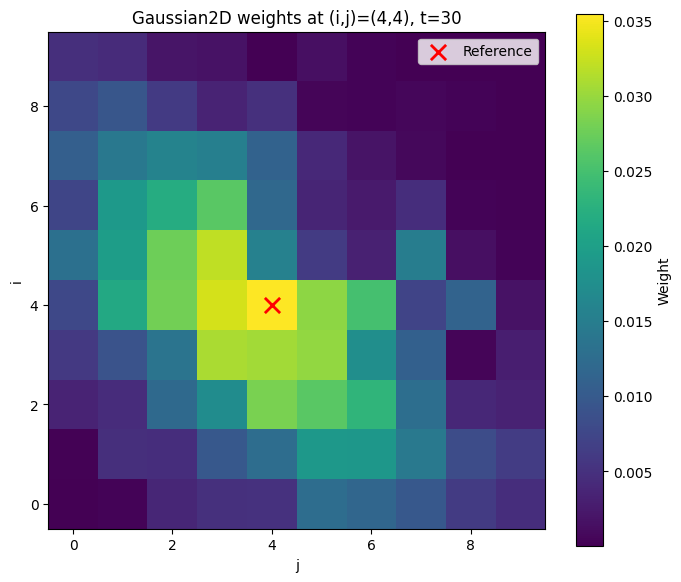

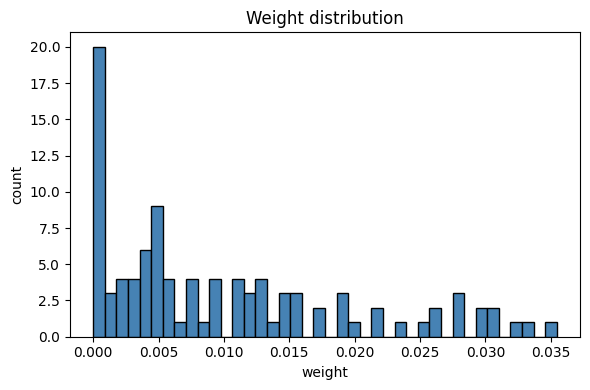

ESS(ref=4,4) = 51.94


In [74]:
# Cell D (replacement) - Adapter from trained Gaussian2D joint model
class Gaussian2DWeightAdapter:
    def __init__(self, trained_model, dist_scale2, mu_scale2, selector_args=None, device="cpu"):
        self.model = trained_model
        self.model.eval()
        self.device = device

        self.cfg = {"mode": "full", "radius": None, "max_points": None, "include_center": True}
        if selector_args is not None:
            self.cfg.update(selector_args)

        self.dist_scale2 = float(max(dist_scale2, 1e-8))
        self.mu_scale2 = float(max(mu_scale2, 1e-8))

        with torch.no_grad():
            mu_all, _, _, h_space, h_mu = self.model.constrained()
        self.mu_all = mu_all.detach().cpu().numpy().astype(np.float64)  # (S,)
        self.h_space = float(h_space.detach().cpu().item())
        self.h_mu = float(h_mu.detach().cpu().item())

    def __call__(self, teacher, i, j, t_idx, data_shape, **kwargs):
        n_time, n_lat, n_lon = data_shape
        target_flat = int(i * n_lon + j)

        mode = str(self.cfg["mode"]).lower()
        if mode == "full":
            ii, jj = np.meshgrid(np.arange(n_lat), np.arange(n_lon), indexing="ij")
            coords = np.column_stack([ii.ravel(), jj.ravel()]).astype(np.int64)
        else:
            sel = select_spatial_neighborhood(
                n_lat=n_lat, n_lon=n_lon, i=i, j=j,
                mode=self.cfg["mode"], radius=self.cfg["radius"],
                max_points=self.cfg["max_points"], include_center=self.cfg["include_center"],
            )
            coords = sel.coords.astype(np.int64)
            if coords.shape[0] == 0:
                coords = np.array([[i, j]], dtype=np.int64)

        flat = coords[:, 0] * n_lon + coords[:, 1]

        d2 = ((coords[:, 0] - i) ** 2 + (coords[:, 1] - j) ** 2).astype(np.float64)
        mu_q = self.mu_all[target_flat]
        mu_n = self.mu_all[flat]
        dmu2 = (mu_n - mu_q) ** 2

        x_space = d2 / self.dist_scale2
        x_mu = dmu2 / self.mu_scale2

        logits = -0.5 * (
            x_space / (self.h_space * self.h_space + 1e-12) +
            x_mu / (self.h_mu * self.h_mu + 1e-12)
        )

        logits = logits - np.max(logits)
        w_loc = np.exp(logits)
        w_loc = w_loc / (w_loc.sum() + 1e-12)

        w_map = np.zeros((n_lat, n_lon), dtype=np.float64)
        w_map[coords[:, 0], coords[:, 1]] = w_loc

        # keep same spatial weights for all times (compatible with your compute_combined_sim usage)
        return np.repeat(w_map[None, :, :], n_time, axis=0)


gaussian2d_adapter = Gaussian2DWeightAdapter(
    trained_model=model,
    dist_scale2=dist_scale2,
    mu_scale2=mu_scale2,
    device=device,
)
print("Gaussian2D adapter ready.")

def threshold_weights_map(w_full, thr=0.3, eps=1e-12):
    """
    w_full: (T,H,W) array from gaussian2d_adapter
    Returns thresholded + renormalized weights per time slice.
    """
    w = np.asarray(w_full, dtype=np.float64).copy()

    # zero-out small weights
    w[w < thr] = 0.0

    # renormalize each time map
    T = w.shape[0]
    for t in range(T):
        s = w[t].sum()
        if s > eps:
            w[t] /= s
        else:
            # fallback: keep all-zero if everything was cut
            # OR set reference point to 1 if you prefer
            pass
    return w

def binarize_weights_map(w_full, thr=0.3, eps=1e-12, renormalize=False):
    """
    Convert weights to hard 0/1 mask by threshold.
    - w < thr -> 0
    - w >= thr -> 1
    Optionally renormalize each time slice to sum to 1.
    """
    w = np.asarray(w_full, dtype=np.float64).copy()
    w = np.where(w >= thr, float(0.001), 0.0)

    if renormalize:
        T = w.shape[0]
        for t in range(T):
            s = w[t].sum()
            if s > eps:
                w[t] /= s
            # else: keep all zeros (or add custom fallback)
    return w


# Plot weights for one reference (i,j) after Cell D
import matplotlib.pyplot as plt
import numpy as np

i_ref, j_ref = 4,4
t_ref = 30  # any valid t index

w_full = gaussian2d_adapter(teacher=None, i=i_ref, j=j_ref, t_idx=t_ref, data_shape=data.shape)
#w_full = binarize_weights_map(w_full, thr=0.01)
print("sum =", w_full[t_ref].sum())


w_map = w_full[t_ref]      # (H,W)

plt.figure(figsize=(7, 6))
im = plt.imshow(w_map, origin="lower", cmap="viridis")
plt.colorbar(im, label="Weight")
plt.scatter([j_ref], [i_ref], c="red", marker="x", s=120, linewidths=2, label="Reference")
plt.title(f"Gaussian2D weights at (i,j)=({i_ref},{j_ref}), t={t_ref}")
plt.xlabel("j")
plt.ylabel("i")
plt.legend()
plt.tight_layout()
plt.show()

# Optional histogram
plt.figure(figsize=(6, 4))
plt.hist(w_map.ravel(), bins=40, color="steelblue", edgecolor="k")
plt.title("Weight distribution")
plt.xlabel("weight")
plt.ylabel("count")
plt.tight_layout()
plt.show()

# Optional: ESS for this reference map
w_flat = w_map.ravel().astype(np.float64)
ess = (np.sum(w_flat) ** 2) / (np.sum(w_flat**2) + 1e-12)
print(f"ESS(ref={i_ref},{j_ref}) = {ess:.2f}")



In [5]:
def gaussian2d_adapter_thr(*args, **kwargs):
    w = gaussian2d_adapter(*args, **kwargs)
    return threshold_weights_map(w, thr=0.01)

def gaussian2d_adapter_binary(*args, **kwargs):
    w = gaussian2d_adapter(*args, **kwargs)
    return binarize_weights_map(w, thr=0.01, renormalize=False)
    
selector_args = {
    "mode": "circle",      # "square" or "circle"
    "radius": None,        # None => full-grid fallback
    "max_points": 52,      # direct control
    "include_center": True
}
results = compute_combined_sim(
    generate_fn=generate_gev_dataset_linear,
    gen_kwargs=gen_kwargs,
    i=4, j=4,
    n_runs=2,
    return_periods=[10, 100, 1000,10000],
    t_idx=30,
    n_jobs_runs=-1,
    verbose=True,
    fit_mode="full",  # if your compute path needs it for callable weights
)


 SIMULATION REPORT | Pixel (4,4) | full | [Unweighted]
 Success: 2/2 (100.0%) | T_idx: 30 | Conf: 95%
---------------------------------------------------------------------------
Metric       | RMSE         | Coverage        | Mean Width      | True        
---------------------------------------------------------------------------
u0           | 1.0542       | 0.00%           | 0.6963          | 83.3333     
sigma0       | 1.7895       | 0.00%           | 0.5381          | 14.9687     
xi0          | 0.0144       | 50.00%          | 0.0260          | 0.1000      
---------------------------------------------------------------------------
RL_10        | 6.2306       | 0.00%           | 1.9697          | 121.1096    
RL_100       | 14.8328      | 0.00%           | 6.8275          | 170.7651    
RL_1000      | 27.8890      | 0.00%           | 17.6537         | 232.2961    
RL_10000     | 47.4478      | 0.00%           | 37.4995         | 309.6410    



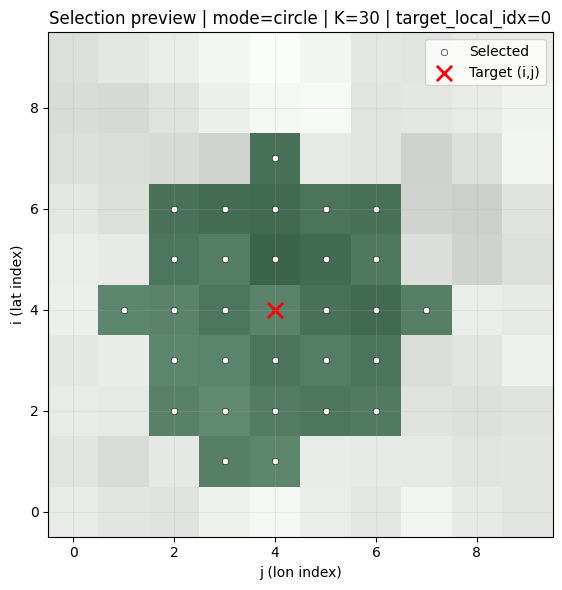

In [50]:
selector_args = {
    "mode": "circle",      # "square" or "circle"
    "radius": None,        # None => full-grid fallback
    "max_points": 30,      # direct control
    "include_center": True
}

preview_selection(
    data_shape=data.shape,  # (T,H,W)
    i=4, j=4,
    selector_args=selector_args,
    background=meta.get("s_field", None)  # optional
)

In [6]:
i,j,t = 4,4,30
for fn,name in [(generate_gev_dataset_linear,"linear"), (generate_gev_dataset_blobs,"blob")]:
    data, meta = fn(**gen_kwargs, seed=2025)
    print(name, "s=", float(meta["s_field"][i,j]),
          "mu=", float(meta["mu"][t,i,j]),
          "sigma=", float(meta["sigma"][t,i,j]),
          "xi=", float(meta["xi"][t,i,j]))


linear s= 0.4444444444444422 mu= 83.33333333333327 sigma= 14.968690001918128 xi= 0.1
blob s= 0.35710624969073906 mu= 80.71318749072218 sigma= 14.089396073572594 xi= 0.1
